# Base Settings

## Library

In [195]:
# Library import

## pandas
import pandas as pd


## numpy
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import seaborn as sns

import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import missingno as msno
import urllib
import re
import random
from openpyxl import load_workbook

from datetime import datetime


import sympy
# Juypter 노트북에서 수학식의 LaTeX 표현을 위해 필요함
sympy.init_printing(use_latex='mathjax')


# from vega_datasets import data
# from tabulate import tabulate

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Google Drive

In [196]:
# Google drive mout
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Path

In [197]:
# 경로 설정
# 기본 디렉토리 경로지정
path_base = '/content/drive/Shareddrives/coding/AIB17/Section1/AIB_section1_project/'

# 데이터 디렉토리 경로지정
path_data = path_base + 'data/'

# 결과 디렉토리 경로지정
path_results = path_base + 'results/'

## 기타 설정

In [198]:
# 그래프 한글폰트 개선
# plt.rcParams['font.family'] ='Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] =False
# plt.rc('font', family='NanumGothic')

In [199]:
# 그래프 한글폰트 개선
# !apt -qq -y install fonts-nanum > /dev/null
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# fm._rebuild()
 
# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'
 
# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

In [200]:
plt.style.use('seaborn')
# plt.style.use('default')
# sns.set(font_scale=1)

# pandas loat format 설정
# pd.options.display.float_format = None                  # float 포멧 초기화
pd.options.display.float_format = '{:.2f}'.format      # 소수점 둘째자리까지 표시
# pd.options.display.float_format = '{:,.2f}'.format      # 천단위 콤마찍고, 소수점 둘째자리까지 표시

# VGCartz



In [201]:
file_name = 'vgchartz.csv' # 최종 스크랩 Date / Time :  2023-01-06 16:00:20
df_raw = pd.read_csv(path_data + file_name) # read
print(df_raw.shape)            # shape
df_raw.head()                  # head()
# Unnamed: 0 컬럼은 불필요함

(62446, 15)


,Unnamed: 0,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,0,Action,God of War,https://www.vgchartz.com/game/226282/god-of-war/,Series,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Mar 05
1,1,Action,Warriors,https://www.vgchartz.com/game/226375/warriors/,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97
2,2,Action,Devil May Cry,https://www.vgchartz.com/game/226043/devil-may...,Series,Capcom,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,16th Oct 01
3,3,Action,God of War (2018),https://www.vgchartz.com/game/230391/god-of-wa...,All,Sony Interactive Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,20th Apr 18
4,4,Action,Dynasty Warriors,https://www.vgchartz.com/game/226374/dynasty-w...,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97


## EDA




In [202]:
df_raw.columns

Index(['Unnamed: 0', 'Genre', 'Name', 'url', 'Platform', 'Publisher',
       'VGC_Score', 'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales',
       'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year'],
      dtype='object')

In [203]:
# 불필요한 컬럼 제거
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year'],
      dtype='object')

### Name

In [204]:
col = df_raw.Name
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Name 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 22953
- 유니크값 갯수     : 39493



In [205]:
# 좌우공백제거
df_raw.Name = df_raw.Name.str.strip()

In [206]:
# 중복값 보기
Name_count = pd.DataFrame(df_raw.Name.value_counts())
filt_p = Name_count.Name != 1
Name_count[filt_p]

,Name
Plants vs. Zombies,19
Monopoly,15
Doom,14
Double Dragon,14
Elite,14
...,...
Cathedral,2
Buku Sudoku,2
Ashen (2018),2
Assassin's Creed Rogue Remastered,2


In [207]:
# Plants vs. Zombies 이 왜 중복된 데이터가 많은지 확인
df_raw[df_raw.Name == 'Plants vs. Zombies']

,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
25085,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/70589/plants-vs-...,PSV,Sony Computer Entertainment,8.0,N/A,N/A,NaN,NaN,NaN,NaN,NaN,21st Feb 12
25086,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72058/plants-vs-...,PS3,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,08th Feb 11
25087,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72059/plants-vs-...,DS,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,18th Jan 11
25088,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72060/plants-vs-...,OSX,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,05th Mar 09
25089,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72062/plants-vs-...,And,Electronic Arts,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Dec 11
25090,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72064/plants-vs-...,X360,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,08th Sep 10
25091,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72066/plants-vs-...,DSi,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Mar 11
25092,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72069/plants-vs-...,And,Electronic Arts,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Dec 11
25093,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72070/plants-vs-...,OSX,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,05th May 09
25094,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72071/plants-vs-...,WinP,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Jun 11


### Platform

In [208]:
col = df_raw.Platform
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Platform 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62366
- 유니크값 갯수     : 80



In [209]:
df_raw.Platform.unique()

array(['Series', 'All', 'PS3', 'PS4', 'PS2', 'X360', 'PC', 'XOne', 'PS',
       'PSP', 'Wii', 'DS', '3DS', '2600', 'NS', 'iOS', 'NES', 'GC',
       'WiiU', 'XB', 'N64', 'GEN', 'GBA', 'GB', 'PSV', 'SNES', 'DC',
       'SAT', 'XBL', 'PSN', '5200', 'OSX', 'And', 'DSiW', 'Lynx', 'SCD',
       'Linux', 'MS', 'WW', 'ZXS', 'ACPC', 'Amig', '7800', 'VC', 'GG',
       'DSi', 'PCE', 'AJ', 'WinP', 'Mob', 'iQue', 'WS', 'NG', 'GIZ',
       '3DO', 'VB', 'GBC', 'Ouya', 'NGage', 'AST', 'MSD', 'S32X', 'PCFX',
       'XS', 'PS5', 'Int', 'CV', 'Arc', 'OR', 'CDi', 'C128', 'CD32',
       'C64', 'BRW', 'FMT', 'MSX', 'ApII', 'Aco', 'BBCM', 'TG16'],
      dtype=object)

##### 플랫폼 데이터프레임만들기

In [210]:
# 웹스크래핑으로 만든 플랫폼 리스트1 불러오기
file_name = 'console_list.csv'
console_list1 = pd.read_csv(path_data + file_name)                # 데이터 읽기

console_list1.drop(columns=['Unnamed: 0'], inplace=True)        # Unnamed: 0 컬럼 제거
console_list1.rename(columns={'0': 'pf_name'}, inplace=True)    # 컬럼 이름 변경
console_list1['pf_name'] = console_list1['pf_name'].str.strip() # 공백 제거

print(console_list1.shape)
console_list1

(90, 1)


,pf_name
0,3DO Interactive Multiplayer
1,Acorn Electron
2,All
3,Amiga
4,Amiga CD32
...,...
85,Xbox 360
86,XBox Live
87,Xbox One
88,Xbox Series


In [211]:
# 웹스크래핑으로 만든 플랫폼 리스트2 불러오기
file_name = 'console_list2.csv'
console_list2 = pd.read_csv(path_data + file_name)                # 데이터 읽기

console_list2.drop(columns=['Unnamed: 0'], inplace=True)        # Unnamed: 0 컬럼 제거
console_list2.rename(columns={'0' : 'pf_name'}, inplace=True)   # 컬럼 이름 변경
console_list2['pf_name'] = console_list2['pf_name'].str.strip() # 공백 제거

console_list2 = pd.DataFrame(console_list2['pf_name'].str.split('(', n=2, expand=True))
console_list2[1] = console_list2[1].str.slice(0,-1)
console_list2[0] = console_list2[0].str.strip()                 # 공백 제거
console_list2[1] = console_list2[1].str.strip()                 # 공백 제거
console_list2.rename(columns={0 : 'pf_name', 1 :'pf_nick'}, inplace=True) # 컬럼 이름 변경

print(console_list2.shape)
console_list2.head()

(51, 2)


,pf_name,pf_nick
0,PlayStation 2,PS2
1,Nintendo DS,DS
2,Nintendo Switch,NS
3,Game Boy,GB
4,PlayStation 4,PS4


In [212]:
# 웹스크래핑으로 만든 플랫폼 리스트 합치기
console_list = pd.merge(left = console_list1, right = console_list2, how = 'left', on = 'pf_name')
console_list

,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,NaN
2,All,NaN
3,Amiga,NaN
4,Amiga CD32,CD32
...,...,...
85,Xbox 360,X360
86,XBox Live,NaN
87,Xbox One,XOne
88,Xbox Series,NaN


In [213]:
print(len(console_list.pf_nick.unique()))
console_list.pf_nick.unique()

46


array(['3DO', nan, 'CD32', '2600', '5200', '7800', 'AJ', 'Lynx', 'CDi',
       'CV', 'FCF', 'FDS', 'GB', 'GBA', 'GC', 'GG', 'GIZ', 'Int', 'Odys',
       'NGage', 'NG', '3DS', 'N64', 'DS', 'NES', 'NS', 'PCFX', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV', 'S32X', 'SCD', 'GEN',
       'MS', 'SAT', 'SNES', 'TG16', 'VB', 'WS', 'XB', 'X360', 'XOne'],
      dtype=object)

###### 결측치 작업1

In [214]:
console_list.isna().sum()

pf_name     0
pf_nick    45
dtype: int64

In [215]:
isna_filt = console_list['pf_nick'].isna()

In [216]:
console_list.loc[isna_filt].iloc[:10]

,pf_name,pf_nick
1,Acorn Electron,NaN
2,All,NaN
3,Amiga,NaN
5,Amstrad CPC,NaN
6,Android,NaN
7,Apple II,NaN
8,Arcade,NaN
14,Atari ST,NaN
15,BBC Micro,NaN
16,Browser,NaN


In [217]:
column = 'pf_nick'

index = console_list.query('pf_name == "Acorn Electron"').index
console_list.loc[index, column] = 'Aco'

index = console_list.query('pf_name == "All"').index
console_list.loc[index, column] = 'All'

index = console_list.query('pf_name == "Amiga"').index
console_list.loc[index, column] = 'Amig'

index = console_list.query('pf_name == "Amstrad CPC"').index
console_list.loc[index, column] = 'ACPC'

index = console_list.query('pf_name == "Android"').index
console_list.loc[index, column] = 'And'

index = console_list.query('pf_name == "Apple II"').index
console_list.loc[index, column] = 'ApII'

index = console_list.query('pf_name == "Arcade"').index
console_list.loc[index, column] = 'Arc'

index = console_list.query('pf_name == "Atari ST"').index
console_list.loc[index, column] = 'AST'

index = console_list.query('pf_name == "BBC Micro"').index
console_list.loc[index, column] = 'BBCM'

index = console_list.query('pf_name == "Browser"').index
console_list.loc[index, column] = 'BRW'

index = console_list.query('pf_name == "Browser"').index
console_list.loc[index, column] = 'BRW'

index = console_list.query('pf_name == "Commodore 128"').index
console_list.loc[index, column] = 'C128'

index = console_list.query('pf_name == "Commodore 64"').index
console_list.loc[index, column] = 'C64'

index = console_list.query('pf_name == "DSi Ware"').index
console_list.loc[index, column] = 'DSiW'

index = console_list.query('pf_name == "FM Towns"').index
console_list.loc[index, column] = 'FMT'

index = console_list.query('pf_name == "Game Boy Color"').index
console_list.loc[index, column] = 'GBC'

index = console_list.query('pf_name == "iOS"').index
console_list.loc[index, column] = 'iOS'

index = console_list.query('pf_name == "iQue"').index
console_list.loc[index, column] = 'iQue'

index = console_list.query('pf_name == "Linux"').index
console_list.loc[index, column] = 'Linux'

index = console_list.query('pf_name == "Mac OS X"').index
console_list.loc[index, column] = 'OSX'

index = console_list.query('pf_name == "MS-DOS"').index
console_list.loc[index, column] = 'MSD'

index = console_list.query('pf_name == "MSX"').index
console_list.loc[index, column] = 'MSX'

index = console_list.query('pf_name == "Oculus Rift"').index
console_list.loc[index, column] = 'OR'

index = console_list.query('pf_name == "Nintendo DSi"').index
console_list.loc[index, column] = 'DSi'

index = console_list.query('pf_name == "Ouya"').index
console_list.loc[index, column] = 'Ouya'

index = console_list.query('pf_name == "PCE"').index
console_list.loc[index, column] = 'PCE'

index = console_list.query('pf_name == "PlayStation Network"').index
console_list.loc[index, column] = 'PSN'

index = console_list.query('pf_name == "Sega Dreamcast"').index
console_list.loc[index, column] = 'DC'

index = console_list.query('pf_name == "Series"').index
console_list.loc[index, column] = 'Series'

index = console_list.query('pf_name == "Standard Mobile"').index
console_list.loc[index, column] = 'Mob'

index = console_list.query('pf_name == "Virtual Console"').index
console_list.loc[index, column] = 'VC'

index = console_list.query('pf_name == "Wii"').index
console_list.loc[index, column] = 'Wii'

index = console_list.query('pf_name == "Wii U"').index
console_list.loc[index, column] = 'WiiU'

index = console_list.query('pf_name == "WiiWare"').index
console_list.loc[index, column] = 'WW'

index = console_list.query('pf_name == "Windows Phone"').index
console_list.loc[index, column] = 'WinP'

index = console_list.query('pf_name == "XBox Live"').index
console_list.loc[index, column] = 'XBL'

index = console_list.query('pf_name == "Xbox Series"').index
console_list.loc[index, column] = 'XS'

index = console_list.query('pf_name == "ZX Spectrum"').index
console_list.loc[index, column] = 'ZXS'

###### 결측치 작업2

In [218]:
console_list.isna().sum()

pf_name    0
pf_nick    8
dtype: int64

In [219]:
isna_filt = console_list['pf_nick'].isna()
console_list.loc[isna_filt]
# 해당 플랫폼들은 데이터가 없기 때문에 제거

,pf_name,pf_nick
31,HTC Vive,NaN
38,Microsoft Windows,NaN
43,Neo Geo X,NaN
44,Nintendo 2DS,NaN
51,Nvidia Shield,NaN
64,Playstation VR,NaN
73,Super Famicom,NaN
76,Unknown,NaN


In [220]:
console_list = console_list.drop(index=console_list.loc[isna_filt].index) # 비어있는 플랫폼
console_list = console_list.sort_values('pf_name')                        # 정렬
console_list = console_list.reset_index(drop=True)                        # 인덱스 재지정

print('💚 console_list 결측치 💚\n', console_list.isna().sum(), '\n')
print('💚 console_list shape 💚\n', console_list.shape, '\n')
console_list

💚 console_list 결측치 💚
 pf_name    0
pf_nick    0
dtype: int64 

💚 console_list shape 💚
 (82, 2) 



,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,Aco
2,All,All
3,Amiga,Amig
4,Amiga CD32,CD32
...,...,...
77,Xbox One,XOne
78,Xbox Series,XS
79,ZX Spectrum,ZXS
80,iOS,iOS


##### 플랫폼 데이터 비교

In [221]:
isin_filt = console_list['pf_nick'].isin(df_raw.Platform)
console_list[~isin_filt]      # 빈 플랫폼은 삭제

,pf_name,pf_nick
23,Fairchild Channel F,FCF
24,Famicom Disk System,FDS
36,Magnavox Odyssey,Odys


In [222]:
console_list = console_list.drop(index=console_list[~isin_filt].index)
console_list = console_list.reset_index(drop=True) # 인덱스 재지정
isin_filt = console_list['pf_nick'].isin(df_raw.Platform)
console_list[~isin_filt] # 빈 플랫폼 없음

,pf_name,pf_nick


In [223]:
print(len(console_list['pf_nick'].unique()))
console_list['pf_nick'].unique()

79


array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PCFX', 'PCE', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X', 'SCD',
       'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16', 'VB',
       'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [224]:
plat_list = pd.DataFrame(df_raw.Platform.unique())
plat_list

,0
0,Series
1,All
2,PS3
3,PS4
4,PS2
...,...
75,MSX
76,ApII
77,Aco
78,BBCM


In [225]:
isin_filt = console_list['pf_nick'].isin(plat_list[0])
console_list[~isin_filt]

,pf_name,pf_nick


In [226]:
print(len(df_raw.Platform.value_counts().sort_index().index))
df_raw.Platform.value_counts().sort_index().index

80


Index(['2600', '3DO', '3DS', '5200', '7800', 'ACPC', 'AJ', 'AST', 'Aco', 'All',
       'Amig', 'And', 'ApII', 'Arc', 'BBCM', 'BRW', 'C128', 'C64', 'CD32',
       'CDi', 'CV', 'DC', 'DS', 'DSi', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC',
       'GEN', 'GG', 'GIZ', 'Int', 'Linux', 'Lynx', 'MS', 'MSD', 'MSX', 'Mob',
       'N64', 'NES', 'NG', 'NGage', 'NS', 'OR', 'OSX', 'Ouya', 'PC', 'PCE',
       'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X',
       'SAT', 'SCD', 'SNES', 'Series', 'TG16', 'VB', 'VC', 'WS', 'WW', 'Wii',
       'WiiU', 'WinP', 'X360', 'XB', 'XBL', 'XOne', 'XS', 'ZXS', 'iOS',
       'iQue'],
      dtype='object')

In [227]:
print(len(console_list['pf_nick'].unique()))
console_list['pf_nick'].unique()

79


array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PCFX', 'PCE', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X', 'SCD',
       'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16', 'VB',
       'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [228]:
isin_filt = plat_list[0].isin(console_list['pf_nick'])
plat_list[~isin_filt]

,0
6,PC


In [229]:
# console_list 에 PC 추가하기
index = len(console_list)+1
console_list.loc[index] = [ 'PC Games', 'PC' ]

In [230]:
console_list.tail()

,pf_name,pf_nick
75,Xbox Series,XS
76,ZX Spectrum,ZXS
77,iOS,iOS
78,iQue,iQue
80,PC Games,PC


In [231]:
console_list = console_list.sort_values('pf_name') # 정렬
console_list = console_list.reset_index(drop=True) # 인덱스 재지정

print('💚 console_list 결측치 💚\n', console_list.isna().sum(), '\n')
print('💚 console_list shape 💚\n', console_list.shape, '\n')
console_list

💚 console_list 결측치 💚
 pf_name    0
pf_nick    0
dtype: int64 

💚 console_list shape 💚
 (80, 2) 



,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,Aco
2,All,All
3,Amiga,Amig
4,Amiga CD32,CD32
...,...,...
75,Xbox One,XOne
76,Xbox Series,XS
77,ZX Spectrum,ZXS
78,iOS,iOS


##### 플랫폼 세대분류
- [Home video game console generations](https://en.wikipedia.org/wiki/Home_video_game_console_generations)

<center>
<img alt="image" 
width=90% 
src="https://upload.wikimedia.org/wikipedia/en/timeline/dvi8hgniehwes0vxhfxxuhflggelxtl.png">  
</center>

In [232]:
# 엑셀저장
file_name = 'console_list_work.xlsx'
# console_list.to_excel(path_data + file_name)

In [233]:
console_list.pf_name.unique()

array(['3DO Interactive Multiplayer', 'Acorn Electron', 'All', 'Amiga',
       'Amiga CD32', 'Amstrad CPC', 'Android', 'Apple II', 'Arcade',
       'Atari 2600', 'Atari 5200', 'Atari 7800', 'Atari Jaguar',
       'Atari Lynx', 'Atari ST', 'BBC Micro', 'Browser', 'CD-i',
       'ColecoVision', 'Commodore 128', 'Commodore 64', 'DSi Ware',
       'FM Towns', 'Game Boy', 'Game Boy Advance', 'Game Boy Color',
       'GameCube', 'GameGear', 'Gizmondo', 'Intellivision', 'Linux',
       'MS-DOS', 'MSX', 'Mac OS X', 'N-Gage', 'Neo Geo', 'Nintendo 3DS',
       'Nintendo 64', 'Nintendo DS', 'Nintendo DSi',
       'Nintendo Entertainment System', 'Nintendo Switch', 'Oculus Rift',
       'Ouya', 'PC Games', 'PC-FX', 'PCE', 'PlayStation', 'PlayStation 2',
       'PlayStation 3', 'PlayStation 4', 'PlayStation 5',
       'PlayStation Network', 'PlayStation Portable', 'PlayStation Vita',
       'Sega 32X', 'Sega CD', 'Sega Dreamcast', 'Sega Genesis',
       'Sega Master System', 'Sega Saturn', 'Series'

In [234]:
console_list.pf_nick.unique()

array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PC', 'PCFX', 'PCE',
       'PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X',
       'SCD', 'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16',
       'VB', 'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [235]:
pf_gens = [5, 2, 8, 2, 5, 2, 8, 1, 1, 2, 
        2, 3, 5, 4, 2, 3, 7, 4, 2, 3, 
        2, 9, 5, 5, 6, 6, 6, 5, 6, 2, 
        8, 3, 2, 8, 6, 4, 7, 5, 6, 6, 
        3, 8, 9, 8, 8, 5, 3, 5, 6, 7, 
        8, 9, 7, 7, 7, 5, 4, 6, 4, 3, 
        4, 0, 8, 4, 4, 7, 7, 7, 8, 7, 
        8, 5, 6, 6, 7, 8, 9, 2, 8, 6]

In [236]:
pf_manufacturer = ['Panasonic', 'Acorn', 'Unknown', 'Commodore', 'Commodore', 'Amstrad', 'Unknown', 'Apple', 'Unknown', 'Atari', 
                'Atari', 'Atari', 'Atari', 'Atari', 'Atari', 'Acorn', 'Unknown', 'Sony', 'Coleco', 'Commodore', 
                'Commodore', 'Nintendo', 'Fujitsu', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 'Sega', 'Tiger Telematics', 'Mattel Electronics', 
                'Unknown', 'Unknown', 'ASCII', 'Unknown', 'Nokia', 'Neo Geo', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 
                'Nintendo', 'Nintendo', 'Oculus', 'Ouya', 'Unknown', 'NEC', 'NEC', 'Sony', 'Sony', 'Sony', 
                'Sony', 'Sony', 'Sony', 'Sony', 'Sony', 'Sega', 'Sega', 'Sega', 'Sega', 'Sega', 
                'Sega', 'Unknown', 'Unknown', 'Nintendo', 'NEC', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 
                'Microsoft', 'Bandai', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Sinclair', '-', 'iQue']

In [237]:
pf_release = ['1993', '1983', '-', '1985', '1993', '1984', '-', '1977', '-', '1977', 
              '1982', '1986', '1993', '1989', '1985', '1981', '-', '1990', '1982', '1985', 
              '1982', '2010', '1989', '1989', '2001', '1998', '2001', '1990', '2005', '1979 ', 
              '-', '-', '1983 ', '-', '2003', '1990', '2011', '1996', '2004', '2008', 
              '1983 ', '2017', '2012', '2013', '-', '1994', '1987', '1994', '2000', '2006 ', 
              '2013', '2020', '2006', '2004', '2011', '1994', '1991', '1998', '1988', '1985 ', 
              '1994', '-', '-', '1990', '1987', '1995', '2006', '2006', '2012', '2012', 
              '2010', '1999', '2002', '2001', '2005', '2013', '2020', '1982', '-', '2002']

In [238]:
pf_type = ['video game console', 'computer', 'computer', 'computer', 'video game console', 'computer', 'mobile', 'computer', 'computer', 'video game console', 
           'video game console', 'video game console', 'video game console', 'Handheld', 'computer', 'computer', 'computer', 'video game console', 'video game console', 'computer', 
           'computer', 'Virtual Reality', 'video game console', 'Handheld', 'Handheld', 'Handheld', 'video game console', 'Handheld', 'Handheld', 'video game console', 
           'computer', 'computer', 'computer', 'computer', 'Handheld', 'video game console', 'Handheld', 'video game console', 'Handheld', 'Handheld', 
           'video game console', 'Handheld', 'Virtual Reality', 'video game console', 'computer', 'video game console', 'video game console', 'video game console', 'video game console', 'video game console', 
           'video game console', 'video game console', 'Online service', 'Handheld', 'Handheld', 'video game console', 'video game console', 'video game console', 'video game console', 'video game console', 
           'video game console', 'computer', 'mobile', 'video game console', 'video game console', 'Virtual Reality', 'Virtual Reality', 'video game console', 'Handheld', 'Virtual Reality', 
           'mobile', 'Handheld', 'Online service', 'video game console', 'video game console', 'video game console', 'video game console', 'computer', 'mobile', 'video game console']

In [239]:
console_list['pf_gens'] = pf_gens
console_list['pf_manufacturer'] = pf_manufacturer
console_list['pf_release'] = pf_release
console_list['pf_type'] = pf_type

In [240]:
console_list.pf_release.replace('-', '9999', inplace=True)
console_list.pf_release = console_list.pf_release.astype(int)

##### 기존 데이터프레임에 플랫폼 정보 merge

In [241]:
df_raw.head()

,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,Action,God of War,https://www.vgchartz.com/game/226282/god-of-war/,Series,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Mar 05
1,Action,Warriors,https://www.vgchartz.com/game/226375/warriors/,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97
2,Action,Devil May Cry,https://www.vgchartz.com/game/226043/devil-may...,Series,Capcom,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,16th Oct 01
3,Action,God of War (2018),https://www.vgchartz.com/game/230391/god-of-wa...,All,Sony Interactive Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,20th Apr 18
4,Action,Dynasty Warriors,https://www.vgchartz.com/game/226374/dynasty-w...,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97


In [242]:
console_list.rename(columns={'pf_nick': 'Platform'}, inplace=True) # 컬럼 이름 변경

In [243]:
console_list.head()

,pf_name,Platform,pf_gens,pf_manufacturer,pf_release,pf_type
0,3DO Interactive Multiplayer,3DO,5,Panasonic,1993,video game console
1,Acorn Electron,Aco,2,Acorn,1983,computer
2,All,All,8,Unknown,9999,computer
3,Amiga,Amig,2,Commodore,1985,computer
4,Amiga CD32,CD32,5,Commodore,1993,video game console


In [244]:
df_raw = pd.merge(left = df_raw, right = console_list, how = 'left', on = 'Platform')

##### 플랫폼 범주화

In [245]:
# 플랫폼 7 범주화
pc_7 = ['PC', 'OSX', 'Series', 'Linux', 'BRW', 'MSD', 'ACPC', 'MSX', 'ApII', 'All']
mobile_7 = ['And', 'iOS', 'WinP', 'Mob']
console_7 = ['PS2', 'PS', 'PS4', 'PS3', 'XOne', 'X360', 'Wii', 'SNES', 'NES', 'XB', 'GEN', 'SAT', 'VC', 'GC', 'DC', 
           '2600', 'PCE', 'XS', 'PS5', 'N64', 'MS', '3DO', 'SCD', 'NG', 'Int', 'DSi', 'AJ', '5200', 'PCFX', '7800', 'CV', 'C64', 
           'Amig', 'Ouya', 'ZXS', 'AST', 'iQue', 'CDi', 'S32X', 'CD32', 'FMT', 'TG16', 'C128', 'Aco', 'BBCM']
portable_7 = ['DS', 'NS', 'PSP', 'GBA', 'GB', '3DS', 'PSV', 'WiiU', 'GG', 'WS', 'Lynx', 'NGage', 'GIZ', 'GBC', ]
arcade_7 = ['Arc']
network_7 = ['XBL', 'PSN']
vr_7 = ['OR', 'VB', 'DSiW', 'WW']

In [246]:
df_raw['Platform_7'] = 'pc'
df_raw.loc[df_raw[df_raw.Platform.isin(mobile_7)].index, 'Platform_7'] = 'mobile'
df_raw.loc[df_raw[df_raw.Platform.isin(console_7)].index, 'Platform_7'] = 'console'
df_raw.loc[df_raw[df_raw.Platform.isin(portable_7)].index, 'Platform_7'] = 'portable'
df_raw.loc[df_raw[df_raw.Platform.isin(arcade_7)].index, 'Platform_7'] = 'arcade'
df_raw.loc[df_raw[df_raw.Platform.isin(network_7)].index, 'Platform_7'] = 'network'
df_raw.loc[df_raw[df_raw.Platform.isin(vr_7)].index, 'Platform_7'] = 'vr'

In [247]:
print('Platform_7 결측치 : ', df_raw['Platform_7'].isna().sum(), '\n')
df_raw['Platform_7'].value_counts()

Platform_7 결측치 :  0 



console     26712
pc          14927
portable    14076
network      4126
mobile       1282
vr           1271
arcade         52
Name: Platform_7, dtype: int64

In [248]:
# 플랫폼 3 범주화
pc_3 = ['PC', 'OSX', 'Series', 'Linux', 'BRW', 'MSD', 'ACPC', 'MSX', 'ApII', 'All']
console_3 = ['PS2', 'PS', 'PS4', 'PS3', 'XOne', 'X360', 'Wii', 'SNES', 'NES', 'XB', 'GEN', 'SAT', 'VC', 'GC', 'DC', 'XBL', 'PSN', 'Arc',
           '2600', 'PCE', 'XS', 'PS5', 'N64', 'MS', '3DO', 'SCD', 'NG', 'Int', 'DSi', 'AJ', '5200', 'PCFX', '7800', 'CV', 'C64', 
           'Amig', 'Ouya', 'ZXS', 'AST', 'iQue', 'CDi', 'S32X', 'CD32', 'FMT', 'TG16', 'C128', 'Aco', 'BBCM', 'OR', 'VB', 'DSiW', 'WW']
portable_3 = ['DS', 'NS', 'PSP', 'GBA', 'GB', '3DS', 'PSV', 'WiiU', 'GG', 'WS', 'Lynx', 'NGage', 'GIZ', 'GBC', 'And', 'iOS', 'WinP', 'Mob']

In [249]:
df_raw['Platform_3'] = 'pc'
df_raw.loc[df_raw[df_raw.Platform.isin(console_3)].index, 'Platform_3'] = 'console'
df_raw.loc[df_raw[df_raw.Platform.isin(portable_3)].index, 'Platform_3'] = 'portable'

In [250]:
print('Platform_3 결측치 : ', df_raw['Platform_3'].isna().sum(), '\n')
df_raw['Platform_3'].value_counts()

Platform_3 결측치 :  0 



console     32161
portable    15358
pc          14927
Name: Platform_3, dtype: int64

### Year

In [251]:
col = df_raw.Year
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Year 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 54626
- 유니크값 갯수     : 7820



In [252]:
# data 확인
df_raw.Year.value_counts()

N/A              5662
01st Jan 94       514
01st Jan 93       451
01st Jan 92       388
01st Jan 95       352
                 ... 
25th Dec 18         1
24th Jun 19         1
20th Feb 04         1
02nd Apr 08         1
11th Aug 16         1
Name: Year, Length: 7820, dtype: int64

In [253]:
df_raw.Year = df_raw.Year.str.strip()

In [254]:
df_raw.Year = df_raw.Year.str.slice(-2,) 

In [255]:
# 결측데이터 보기
df_raw.Year.isna().sum() # 결측치 없음

0

In [256]:
df_raw.loc[df_raw[df_raw.Year == '/A'].index, 'Year'] = '9999'

In [257]:
df_raw.Year.value_counts()

9999    5662
09      4358
10      3587
11      3390
08      2935
14      2896
07      2525
06      2095
05      1810
13      1739
02      1724
03      1720
15      1676
04      1600
12      1581
17      1557
00      1546
18      1529
01      1475
20      1455
16      1347
19      1288
99      1272
96      1224
94      1162
95      1150
98      1092
97      1036
93      1034
92       933
91       780
90       657
89       427
21       404
83       297
88       293
87       270
82       211
86       158
22       115
85       101
84        99
70        82
81        50
78        45
80        35
77        11
79         8
23         2
71         1
75         1
73         1
Name: Year, dtype: int64

In [258]:
df_raw.Year = df_raw.Year.astype(int) # 데이터타입 정수형으로 변환
df_raw.Year.dtypes

dtype('int64')

In [259]:
print(f"""\
출시년도가 40 이하인 케이스 수    : {df_raw.query('Year <= 40').shape[0]}
40 < 출시년도 <=99 케이스 수      : {df_raw.query('Year > 40 & Year <= 99').shape[0]}
""")

출시년도가 40 이하인 케이스 수    : 44354
40 < 출시년도 <=99 케이스 수      : 12430



In [260]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3'],
      dtype='object')

In [261]:
filt_40 = df_raw.Year <= 40 # 출시년도가 40 이하인 케이스 필터링
df_raw[filt_40].index
df_raw.loc[df_raw[filt_40].index, 'Year'] = df_raw.loc[df_raw[filt_40].index, 'Year'] + 2000 # 기존값에 +2000
df_raw[filt_40].Year.value_counts() # 출시년도가 40 이하인 케이스 +2000 완료

2009    4358
2010    3587
2011    3390
2008    2935
2014    2896
2007    2525
2006    2095
2005    1810
2013    1739
2002    1724
2003    1720
2015    1676
2004    1600
2012    1581
2017    1557
2000    1546
2018    1529
2001    1475
2020    1455
2016    1347
2019    1288
2021     404
2022     115
2023       2
Name: Year, dtype: int64

In [262]:
filt_99 = df_raw.Year <= 99 # 출시년도가 99 이하인 케이스 필터링
df_raw[filt_99].index
df_raw.loc[df_raw[filt_99].index, 'Year'] = df_raw.loc[df_raw[filt_99].index, 'Year'] + 1900 # 기존값에 +1900
df_raw[filt_99].Year.value_counts() # 출시년도가 30 이하인 케이스 +1900 완료

1999    1272
1996    1224
1994    1162
1995    1150
1998    1092
1997    1036
1993    1034
1992     933
1991     780
1990     657
1989     427
1983     297
1988     293
1987     270
1982     211
1986     158
1985     101
1984      99
1970      82
1981      50
1978      45
1980      35
1977      11
1979       8
1971       1
1975       1
1973       1
Name: Year, dtype: int64

In [263]:
df_raw.Year.unique()

array([2005, 1997, 2001, 2018, 2013, 1981, 2014, 2004, 2016, 2002, 2015,
       2008, 2020, 2011, 1988, 2010, 2009, 1999, 2019, 1998, 2007, 2022,
       2006, 2000, 1996, 2017, 1982, 2003, 1985, 1989, 2012, 1990, 9999,
       1995, 2021, 1991, 1994, 1992, 1977, 1986, 1993, 1984, 1983, 1987,
       1978, 1979, 1970, 1980, 2023, 1971, 1975, 1973])

In [264]:
filt = df_raw.Year < 1983
df_raw[filt].shape

(445, 21)

### Genre

In [265]:
col = df_raw.Genre
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Genre 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62426
- 유니크값 갯수     : 20



##### 장르 : 범주 축소

- action = 'Action','Fighting','Shooter'
- rpg = 'MMO','Party','Role-Playing','Sandbox'
- adventure = 'Action-Adventure','Adventure','Platform','Visual Novel'
- simul = 'Simulation','Strategy'
- sports = 'Racing','Sports'
- misc = 'Board Game','Education','Misc','Music','Puzzle'

In [266]:
action = ['Action','Fighting','Shooter']
rpg = ['MMO','Party','Role-Playing','Sandbox']
adventure = ['Action-Adventure','Adventure','Platform','Visual Novel']
simul = ['Simulation','Strategy']
sports = ['Racing','Sports']
misc = ['Board Game','Education','Misc','Music','Puzzle']

In [267]:
df_raw['gen_6'] = 'action'
df_raw.loc[df_raw[df_raw.Genre.isin(rpg)].index, 'gen_6'] = 'rpg'
df_raw.loc[df_raw[df_raw.Genre.isin(adventure)].index, 'gen_6'] = 'adventure'
df_raw.loc[df_raw[df_raw.Genre.isin(simul)].index, 'gen_6'] = 'simul'
df_raw.loc[df_raw[df_raw.Genre.isin(sports)].index, 'gen_6'] = 'sports'
df_raw.loc[df_raw[df_raw.Genre.isin(misc)].index, 'gen_6'] = 'misc'

In [268]:
df_raw['gen_6'].value_counts()

action       15949
misc         13061
adventure    12083
sports        8896
simul         6665
rpg           5792
Name: gen_6, dtype: int64

### Publisher

In [269]:
col = df_raw.Publisher
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Publisher 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 59079
- 유니크값 갯수     : 3367



### XX_Score

In [270]:
col = df_raw.VGC_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

VGC_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62367
- 유니크값 갯수     : 79



In [271]:
df_raw.VGC_Score.value_counts()

N/A      60287
7.0        255
8.0        201
6.0        165
9.0         92
         ...  
1.1          1
3.4          1
1.5          1
4.7          1
3.1          1
Name: VGC_Score, Length: 79, dtype: int64

In [272]:
df_raw.VGC_Score = df_raw.VGC_Score.str.strip() # 좌우 공백 제거

In [273]:
# 다른 점수로 대체
df_raw.loc[(df_raw.VGC_Score.str.contains('N/A')) & (df_raw.Critic_Score.str.contains('[09]')), 'VGC_Score'] = df_raw['Critic_Score']
df_raw.loc[(df_raw.VGC_Score.str.contains('N/A')) & (df_raw.User_Score.str.contains('[09]')), 'VGC_Score'] = df_raw['User_Score']
df_raw.VGC_Score.value_counts() # 2034개 대체 됨

N/A      58252
8.0        324
7.0        310
7.0        255
8.0        201
         ...  
9.7          1
3.6          1
2.9          1
2.6          1
3.1          1
Name: VGC_Score, Length: 106, dtype: int64

In [274]:
col = df_raw.Critic_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Critic_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62356
- 유니크값 갯수     : 90



In [275]:
df_raw.Critic_Score.value_counts()

N/A      55892
8.0        347
7.0        329
7.5        271
6.0        201
         ...  
2.1          2
1.3          1
1.2          1
1.8          1
1.4          1
Name: Critic_Score, Length: 90, dtype: int64

In [276]:
df_raw.Critic_Score = df_raw.Critic_Score.str.strip() # 좌우 공백 제거

In [277]:
# 다른 점수로 대체
df_raw.loc[(df_raw.Critic_Score.str.contains('N/A')) & (df_raw.VGC_Score.str.contains('[09]')), 'Critic_Score'] = df_raw['VGC_Score']
df_raw.loc[(df_raw.Critic_Score.str.contains('N/A')) & (df_raw.User_Score.str.contains('[09]')), 'Critic_Score'] = df_raw['User_Score']
df_raw.Critic_Score.value_counts() # 830개 대체됨

N/A      55061
7.0        539
8.0        480
6.0        348
7.5        271
         ...  
1.3          1
1.9          1
1.2          1
8.9          1
1.4          1
Name: Critic_Score, Length: 109, dtype: int64

In [278]:
col = df_raw.User_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

User_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62446,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62390
- 유니크값 갯수     : 56



In [279]:
df_raw.User_Score.value_counts()

N/A       62042
9.0          43
8.0          43
10.0         23
7.0          22
8.5          22
9.5          21
9.1          16
9.3          14
7.5          13
6.0          11
8.3          11
9.6           9
9.2           9
9.7           8
8.9           8
8.6           8
7.6           7
8.2           7
8.4           7
8.8           7
7.2           6
5.0           6
8.7           6
6.5           6
9.8           6
9.4           6
8.1           5
4.0           5
7.9           4
6.9           4
3.0           4
6.8           4
7.8           4
2.0           3
1.0           2
4.5           2
7.3           2
7.7           2
3.9           2
5.5           1
6.7           1
4.8           1
7.1           1
6.6           1
2.5           1
5.7           1
5.8           1
1.9           1
2.7           1
6.4           1
4.1           1
3.8           1
7.4           1
6.3           1
4.9           1
Name: User_Score, dtype: int64

In [280]:
df_raw.User_Score = df_raw.User_Score.str.strip() # 좌우 공백 제거

In [281]:
62033 - 59032

3001

In [282]:
# 다른 점수로 대체
df_raw.loc[(df_raw.User_Score.str.contains('N/A')) & (df_raw.VGC_Score.str.contains('[09]')), 'User_Score'] = df_raw['VGC_Score']
df_raw.loc[(df_raw.User_Score.str.contains('N/A')) & (df_raw.Critic_Score.str.contains('[09]')), 'User_Score'] = df_raw['Critic_Score']
df_raw.User_Score.value_counts() # 3001개 대체 됨

N/A      59043
7.0        291
7.0        291
8.0        289
8.0        264
         ...  
5.8          1
3.8          1
2.7          1
6.4          1
7.1          1
Name: User_Score, Length: 85, dtype: int64

In [283]:
# 남아있는 N/A 5.55 로 대체
df_raw.replace('N/A', 5.55, inplace=True)

In [284]:
# float 변환
df_raw['VGC_Score'] = df_raw['VGC_Score'].astype(float)
df_raw['Critic_Score'] = df_raw['Critic_Score'].astype(float)
df_raw['User_Score'] = df_raw['User_Score'].astype(float)

In [285]:
df_raw[['VGC_Score', 'Critic_Score', 'User_Score']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62446 entries, 0 to 62445
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VGC_Score     62446 non-null  float64
 1   Critic_Score  62446 non-null  float64
 2   User_Score    62446 non-null  float64
dtypes: float64(3)
memory usage: 3.9 MB


In [286]:
# Score 변수 만들기
df_raw['Score'] = (df_raw.VGC_Score + df_raw.Critic_Score + df_raw.User_Score) / 3

### XX_Sales

In [287]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3',
       'gen_6', 'Score'],
      dtype='object')

In [288]:
region_list = ['NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales']

In [289]:
df_raw[region_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62446 entries, 0 to 62445
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NA_Sales     13659 non-null  object
 1   PAL_Sales    14023 non-null  object
 2   JP_Sales     7675 non-null   object
 3   Other_Sales  16368 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [290]:
for i in region_list:
  print(i, ' : ', df_raw[i].str.contains(pat='[^\d]', regex=True).sum()) # 숫자가 아닌것

NA_Sales  :  13659
PAL_Sales  :  14023
JP_Sales  :  7675
Other_Sales  :  16368


In [291]:
for i in region_list:
  print(df_raw[i].str.contains(pat='[m]', regex=True).sum()) # m이 있는 것

13659
14023
7675
16368


In [292]:
for i in region_list:
  index_m = df_raw[i].str.contains(pat='[m]', regex=True).index   # m이 붙어있는 것들의 인덱스 저장
  df_raw[i].replace('[a-zA-Z]', '', regex=True, inplace=True)     # 문자 제거
  df_raw[i] = df_raw[i].astype(float)                             # 테이터타입 소수형 변형
  df_raw.loc[index_m, i] = df_raw.loc[index_m, i] * 1000000       # 기존값에 x 1 million

In [293]:
df_raw[region_list].describe()

,NA_Sales,PAL_Sales,JP_Sales,Other_Sales
count,13659.00,14023.00,7675.00,16368.00
mean,345520.17,192795.41,181822.80,53543.50
std,905177.88,584651.03,447590.83,195824.45
min,0.00,0.00,0.00,0.00
25%,50000.00,10000.00,20000.00,0.00
50%,130000.00,40000.00,50000.00,10000.00
75%,320000.00,160000.00,160000.00,40000.00
max,41360000.00,29020000.00,10220000.00,10570000.00


In [294]:
df_raw[region_list].shape

(62446, 4)

In [295]:
# 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales' 모두 결측인 케이스
filt = df_raw.NA_Sales.isna() & df_raw.PAL_Sales.isna() & df_raw.JP_Sales.isna() & df_raw.Other_Sales.isna()
df_raw[filt].shape

(42141, 23)

##### rc_df (Region Cleaned Data Frame)

In [296]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3',
       'gen_6', 'Score'],
      dtype='object')

In [297]:
# 모든 지역의 판매량이 결측인 데이터 제거 = Region Cleaned Data Frame (rc_df)
rc_df = df_raw.drop(index=df_raw[filt].index)

In [298]:
rc_df[region_list].isna().sum()

NA_Sales        6646
PAL_Sales       6282
JP_Sales       12630
Other_Sales     3937
dtype: int64

In [299]:
# 남아있는 결측은 0으로 대체
for region in region_list:
  rc_df[region].fillna(0, inplace=True)

In [300]:
rc_df[region_list].isna().sum()

NA_Sales       0
PAL_Sales      0
JP_Sales       0
Other_Sales    0
dtype: int64

In [301]:
print(rc_df.shape)
rc_df[region_list].describe()

(20305, 23)


,NA_Sales,PAL_Sales,JP_Sales,Other_Sales
count,20305.00,20305.00,20305.00,20305.00
mean,232428.47,133147.99,68726.42,43161.78
std,759895.74,493965.58,288949.29,177086.71
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,50000.00,10000.00,0.00,10000.00
75%,200000.00,90000.00,30000.00,30000.00
max,41360000.00,29020000.00,10220000.00,10570000.00


In [302]:
# 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales' 를 롱타입으로 변환
df = pd.melt(rc_df, id_vars=['Genre', 'Name', 'url', 'Platform', 'Publisher', 'Score', 'VGC_Score',\
                                'Critic_Score', 'User_Score', 'Total_Sales', 'Year', 'pf_name', 'pf_gens', 'pf_manufacturer', \
                                'pf_release', 'pf_type', 'Platform_7', 'Platform_3', 'gen_6'],
                        var_name='region', value_name='sales') 

In [303]:
# 지역명에서 _sales 제거
df.region = df.region.str.slice(0,-6)
df.head()

,Genre,Name,url,Platform,Publisher,Score,VGC_Score,Critic_Score,User_Score,Total_Sales,...,pf_name,pf_gens,pf_manufacturer,pf_release,pf_type,Platform_7,Platform_3,gen_6,region,sales
0,Action,Grand Theft Auto V,https://www.vgchartz.com/game/65884/grand-thef...,PS3,Rockstar Games,9.47,9.50,9.40,9.50,20.32m,...,PlayStation 3,7,Sony,2006,video game console,console,console,action,NA,6370000.00
1,Action,God of War (2018),https://www.vgchartz.com/game/120125/god-of-wa...,PS4,Sony Interactive Entertainment,9.57,9.00,9.70,10.00,6.15m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,2830000.00
2,Action,Grand Theft Auto V,https://www.vgchartz.com/game/83196/grand-thef...,PS4,Rockstar Games,9.70,9.70,9.70,9.70,19.39m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,6060000.00
3,Action,Grand Theft Auto: San Andreas,https://www.vgchartz.com/game/3427/grand-theft...,PS2,Rockstar Games,9.50,9.50,9.50,9.50,20.81m,...,PlayStation 2,6,Sony,2000,video game console,console,console,action,NA,9430000.00
4,Action,Uncharted 4: A Thief's End,https://www.vgchartz.com/game/77189/uncharted-...,PS4,Sony Interactive Entertainment,9.20,9.20,9.20,9.20,10.33m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,4490000.00


In [304]:
# 판매량이 0인 케이스 제거
filt = df.sales == 0
df.drop(index=df[filt].index, inplace=True)
filt = df.sales == 0
df['sales'] = df['sales'].astype(int)         # 데이터 타입 정수형으로 변환
df[filt].shape

(0, 21)

In [305]:
df.shape

(43308, 21)

##### Total_Sales

In [306]:
rc_df.Total_Sales.str.contains(pat='[^\d]', regex=True).sum() # 숫자가 아닌것

20305

In [307]:
rc_df.Total_Sales.str.contains(pat='[m]', regex=True).sum() # m이 있는 것

20305

In [308]:
index_m = rc_df.Total_Sales.str.contains(pat='[m]', regex=True).index        # m이 붙어있는 것들의 인덱스 저장
rc_df.Total_Sales.replace('[a-zA-Z]', '', regex=True, inplace=True)          # 문자 제거
rc_df.Total_Sales = rc_df.Total_Sales.astype(float)                             # 테이터타입 소수형 변형
rc_df.loc[index_m, 'Total_Sales'] = rc_df.loc[index_m, 'Total_Sales'] * 1000000 # 기존값에 x 1 million
rc_df.Total_Sales.describe()

count      20305.00
mean      477706.97
std      1471764.96
min            0.00
25%        40000.00
50%       130000.00
75%       410000.00
max     82650000.00
Name: Total_Sales, dtype: float64

In [309]:
# totla sales 데이터프레임 저장
df_total = rc_df[['Genre', 'Name', 'url', 'Platform', 'Publisher', 'Score', 'VGC_Score',\
       'Critic_Score', 'User_Score', 'Total_Sales', 'Year', 'pf_name',\
       'pf_gens', 'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7',\
       'Platform_3', 'gen_6']]

In [310]:
print(df_total.shape)
df_total.head()

(20305, 19)


,Genre,Name,url,Platform,Publisher,Score,VGC_Score,Critic_Score,User_Score,Total_Sales,Year,pf_name,pf_gens,pf_manufacturer,pf_release,pf_type,Platform_7,Platform_3,gen_6
5,Action,Grand Theft Auto V,https://www.vgchartz.com/game/65884/grand-thef...,PS3,Rockstar Games,9.47,9.50,9.40,9.50,20320000.00,2013,PlayStation 3,7,Sony,2006,video game console,console,console,action
7,Action,God of War (2018),https://www.vgchartz.com/game/120125/god-of-wa...,PS4,Sony Interactive Entertainment,9.57,9.00,9.70,10.00,6150000.00,2018,PlayStation 4,8,Sony,2013,video game console,console,console,action
8,Action,Grand Theft Auto V,https://www.vgchartz.com/game/83196/grand-thef...,PS4,Rockstar Games,9.70,9.70,9.70,9.70,19390000.00,2014,PlayStation 4,8,Sony,2013,video game console,console,console,action
9,Action,Grand Theft Auto: San Andreas,https://www.vgchartz.com/game/3427/grand-theft...,PS2,Rockstar Games,9.50,9.50,9.50,9.50,20810000.00,2004,PlayStation 2,6,Sony,2000,video game console,console,console,action
10,Action,Uncharted 4: A Thief's End,https://www.vgchartz.com/game/77189/uncharted-...,PS4,Sony Interactive Entertainment,9.20,9.20,9.20,9.20,10330000.00,2016,PlayStation 4,8,Sony,2013,video game console,console,console,action


## 분석

### 지역에 따른 평균 비디오게임 판매량의 차이

In [311]:
NA = df.region == "NA"
PAL = df.region == "PAL"
JP = df.region == "JP"
Other = df.region == "Other"
filt_year = df.Year == 9999

In [312]:
# 지역별 판매량 기술통계
Count = df.groupby('region').count()['sales']
Total = df.groupby('region').sum()['sales']
Mean = df.groupby('region').mean()['sales']
S_Dev = df.groupby('region').std()['sales']

data = {
    'Count' : Count,
    'Total' : Total,
    'Mean' : Mean,
    'S_Dev' : S_Dev,
}

results = pd.DataFrame(data)

# 분석결과 저장
file_name = '01_summary.xlsx'      # 저장파일 이름 지정
results.to_excel(path_results + file_name)  # 엑셀 저장

results

,Count,Total,Mean,S_Dev
region,,,,
JP,7248,1395489996,192534.49,458343.73
NA,13370,4719459978,352988.78,913467.25
Other,10989,876399999,79752.48,234582.74
PAL,11701,2703569989,231054.61,633098.41


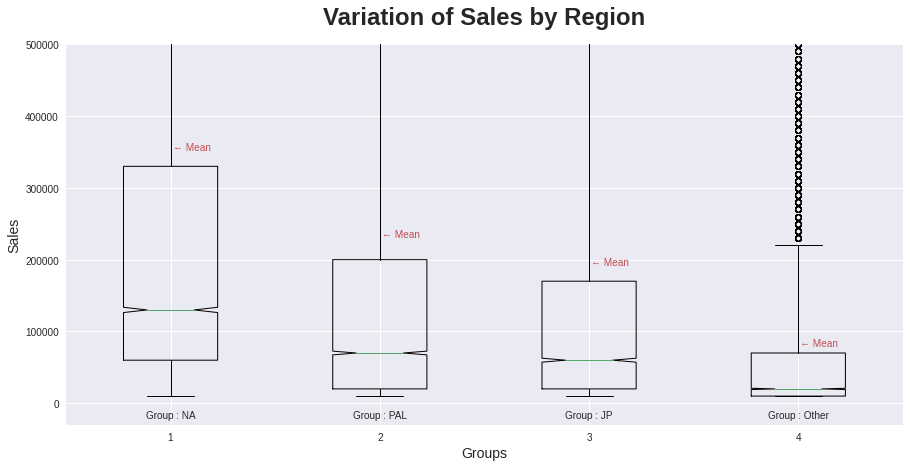

In [313]:
# box plot을 그리기 위한 그룹 지정
group1 = df[NA]['sales']
group2 = df[PAL]['sales']
group3 = df[JP]['sales']
group4 = df[Other]['sales']

plot_data = [group1, group2, group3, group4]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 7))

ax = plt.boxplot(plot_data, notch=True, whis=2.5)
plt.ylim(-30000, 500000)

plt.title('Variation of Sales by Region', fontsize=24, fontweight = 'bold', pad=20)

plt.xlabel('Groups', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.text(1, -20000, 'Group : NA', ha='center')
plt.text(2, -20000, 'Group : PAL', ha='center')
plt.text(3, -20000, 'Group : JP', ha='center')
plt.text(4, -20000, 'Group : Other', ha='center')


plt.text(1.01, df[NA].mean()['sales'], '← Mean', c='r')
plt.text(2.01, df[PAL].mean()['sales'], '← Mean', c='r')
plt.text(3.01, df[JP].mean()['sales'], '← Mean', c='r')
plt.text(4.01, df[Other].mean()['sales'], '← Mean', c='r')

plt.show()

# 분석결과 저장
file_name = '01_boxplot.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

In [314]:
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4)      # 일원분산분석
posthoc = pairwise_tukeyhsd(df.sales, df.region, alpha=0.05)            # 사후검정 : tukey HSD

results = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])  # 사후검정 결과 저장

print(f"""일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}
""")

# 분석결과 저장
file_name = '01_oneway_anova_posthoc_tukeyhsd.xlsx'       # 파일명
results.to_excel(path_results + file_name)                # 저장

wb = load_workbook(path_results + file_name)              # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Post hoc-tukey HSD')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기

results

일원분산분석 결과
F = 368.546, p = 0.000



,group1,group2,meandiff,p-adj,lower,upper,reject
0,JP,NA,160454.29,0.00,136312.66,184595.92,True
1,JP,Other,-112782.01,0.00,-137826.18,-87737.84,True
2,JP,PAL,38520.12,0.00,13780.63,63259.61,True
3,NA,Other,-273236.30,0.00,-294547.26,-251925.34,True
4,NA,PAL,-121934.17,0.00,-142886.23,-100982.11,True
5,Other,PAL,151302.13,0.00,129316.20,173288.06,True


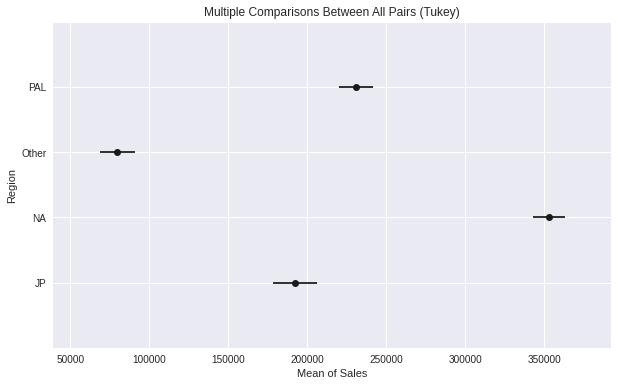

In [315]:
fig = posthoc.plot_simultaneous() # 사후검정 시각화 그래프

plt.xlabel('Mean of Sales')
plt.ylabel('Region')

# 분석결과 저장
file_name = '01_posthoc_graph.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

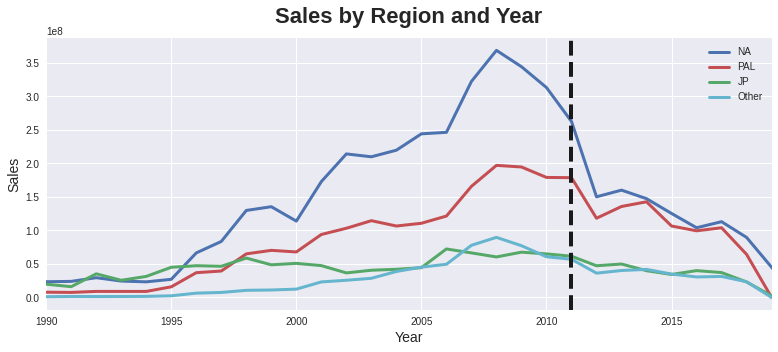

In [316]:
NA = df.region == "NA"
PAL = df.region == "PAL"
JP = df.region == "JP"
Other = df.region == "Other"
filt_year = df.Year == 9999

## 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 5))

# NA 그래프
x_NA = df[~filt_year][NA].groupby('Year').sum()['sales'].index
y_NA = df[~filt_year][NA].groupby('Year').sum()['sales'].values
ax.plot(x_NA, y_NA, label='NA', lw='3', color='b')

# PAL 그래프
x_PAL = df[~filt_year][PAL].groupby('Year').sum()['sales'].index
y_PAL = df[~filt_year][PAL].groupby('Year').sum()['sales'].values
ax.plot(x_PAL, y_PAL, label='PAL', lw='3', color='r')

# JP 그래프
x_JP = df[~filt_year][JP].groupby('Year').sum()['sales'].index
y_JP = df[~filt_year][JP].groupby('Year').sum()['sales'].values
ax.plot(x_JP, y_JP, label='JP', lw='3', color='g')

# Other 그래프
x_Other = df[~filt_year][Other].groupby('Year').sum()['sales'].index
y_Other = df[~filt_year][Other].groupby('Year').sum()['sales'].values
ax.plot(x_Other, y_Other, label='Other', lw='3', color='c')

# 세로라인
plt.axvline(2011, 0, 1, color='k', linestyle='--', linewidth=4)

## 그래프 설정
plt.title('Sales by Region and Year', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.xlim(1990, 2019)
ax.legend()
plt.show()

# 분석결과 저장
file_name = '01_Sales_by_Region_and_Year.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

In [317]:
# 2011년 이후 분산분석
filt_2011 = (df.Year > 2011) & (df.Year < 3000)
group1 = df[filt_2011][NA]['sales']
group2 = df[filt_2011][PAL]['sales']
group3 = df[filt_2011][JP]['sales']
group4 = df[filt_2011][Other]['sales']

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4)
posthoc = pairwise_tukeyhsd(df[filt_2011].sales, df[filt_2011].region, alpha=0.05)

results = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])

print(f"""일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}
""")

# 분석결과 저장
file_name = '01_after_2011.xlsx' # 파일명
results.to_excel(path_results + file_name) # 저장

wb = load_workbook(path_results + file_name) # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Post hoc-tukey HSD')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기

results

일원분산분석 결과
F = 131.427, p = 0.000



,group1,group2,meandiff,p-adj,lower,upper,reject
0,JP,NA,206541.79,0.00,168467.11,244616.48,True
1,JP,Other,-20990.33,0.51,-59828.84,17848.17,False
2,JP,PAL,185771.76,0.00,146999.51,224544.02,True
3,NA,Other,-227532.13,0.00,-265060.18,-190004.07,True
4,NA,PAL,-20770.03,0.48,-58229.52,16689.46,False
5,Other,PAL,206762.09,0.00,168526.50,244997.69,True


### 지역에따라 선호하는 게임의 장르가 있을까?

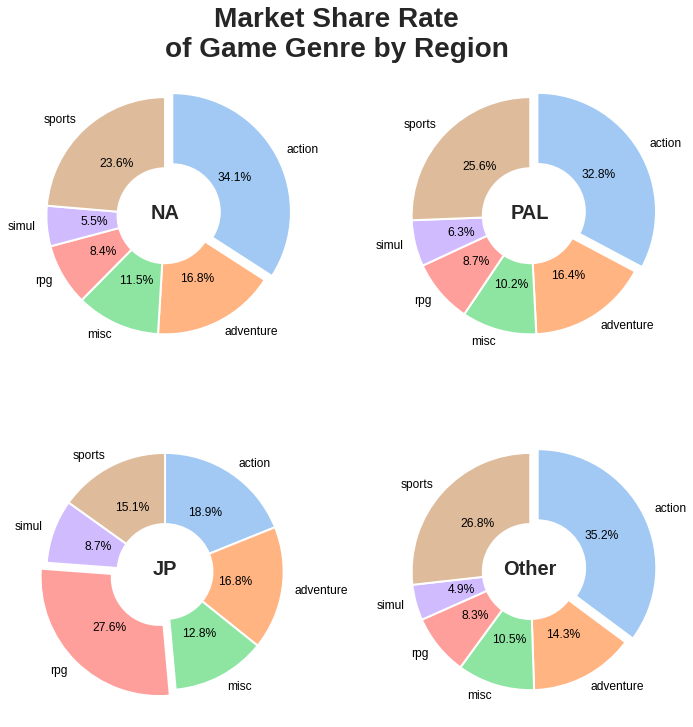

In [318]:

values_NA = df[NA].groupby('gen_6').sum()['sales'].values
labels_NA = df[NA].groupby('gen_6').sum()['sales'].index

values_PAL = df[PAL].groupby('gen_6').sum()['sales'].values
labels_PAL = df[PAL].groupby('gen_6').sum()['sales'].index

values_JP = df[JP].groupby('gen_6').sum()['sales'].values
labels_JP = df[JP].groupby('gen_6').sum()['sales'].index

values_Other = df[Other].groupby('gen_6').sum()['sales'].values
labels_Other = df[Other].groupby('gen_6').sum()['sales'].index

## 그래프 그리기
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

text_dic = dict(rotation=0,size=12, weight=5, color="black")

ax[0][0].pie(values_NA, labels=labels_NA,
    radius=1,
    explode=(0.07,0,0,0,0,0),
    autopct='%.1f%%',
    textprops=text_dic,
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[0][1].pie(values_PAL, labels=labels_PAL, 
    radius=1,
    explode=(0.07,0,0,0,0,0),
    autopct='%.1f%%', 
    textprops=text_dic,
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[1][0].pie(values_JP, labels=labels_JP, 
    radius=1,
    explode=(0,0,0,0.07,0,0),
    autopct='%.1f%%', 
    textprops=text_dic,
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[1][1].pie(values_Other, labels=labels_Other, 
    radius=1,
    explode=(0.07,0,0,0,0,0),
    autopct='%.1f%%', 
    textprops=text_dic,
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)


## 그래프 설정
# 전체 그래프 제목
fig.suptitle('Market Share Rate\nof Game Genre by Region', fontsize=28, fontweight = 'bold', y=0.95)

# 그래프별 제목
ax[0][0].set_title('NA', fontsize=20, fontweight = 'bold', y=0.47)
ax[0][1].set_title('PAL', fontsize=20, fontweight = 'bold', y=0.47)
ax[1][0].set_title('JP', fontsize=20, fontweight = 'bold', y=0.47)
ax[1][1].set_title('Other', fontsize=20, fontweight = 'bold', y=0.47)

plt.show()

# 분석결과 저장
file_name = '02_region_genre_pie.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')


           Count       Total      Mean  Rate
action      4132  1609919995 389622.46  0.34
sports      3223  1116099992 346292.27  0.24
adventure   2038   794399995 389793.91  0.17
misc        1833   540799998 295035.46  0.11
rpg         1050   398449999 379476.19  0.08
simul       1094   259789999 237468.01  0.06

일원분산분석 결과
F = 7.194, p = 0.000

       group1     group2   meandiff  p-adj      lower     upper  reject
0      action  adventure     171.46   0.90  -70218.15  70561.06   False
1      action       misc  -94587.00   0.00 -167565.01 -21608.98    True
2      action        rpg  -10146.27   0.90 -100017.79  79725.26   False
3      action      simul -152154.45   0.00 -240573.15 -63735.76    True
4      action     sports  -43330.19   0.33 -104442.57  17782.20   False
5   adventure       misc  -94758.45   0.02 -178468.29 -11048.62    True
6   adventure        rpg  -10317.72   0.90 -109102.52  88467.08   False
7   adventure      simul -152325.91   0.00 -249790.83 -54860.98    True
8  

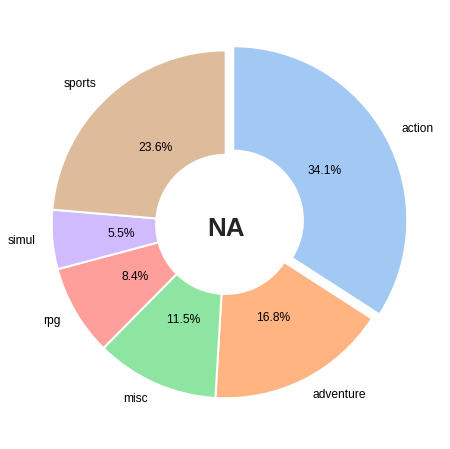

In [319]:
# NA 지역의 비디오게임 장르 분포
## 설정
region = NA # 지역 설정
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

## Pie Graph
values = df[region].groupby('gen_6').sum()['sales'].values
labels = df[region].groupby('gen_6').sum()['sales'].index

fig, ax = plt.subplots(figsize=(8,8))
text_dic = dict(rotation=0,size=12, weight=5, color="black")

ax.pie(values, labels=labels,
    radius=1,
    explode=(0.05,0,0,0,0,0),
    autopct='%.1f%%',
    textprops=text_dic,
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)

ax.set_title(df[region].region.unique()[0], fontsize=26, fontweight = 'bold', y=0.46)

## Summary
idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Count' : [group1.count(), group2.count(), group3.count(), group4.count(), group5.count(), group6.count()],
    'Total' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Mean' : [group1.mean(), group2.mean(), group3.mean(), group4.mean(), group5.mean(), group6.mean()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

results_summary = pd.DataFrame(data, index=idx)

## One-Way ANOVA
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

results_posthoc = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])

print(f"""
{results_summary.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{results_posthoc}
""")

# 분석결과 저장
file_name = '02_na_genre_pie.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

file_name = '02_na_genre_posthoc.xlsx'
results_posthoc.to_excel(path_results + file_name)

file_name = '02_na_genre_summary.xlsx'
results_summary.to_excel(path_results + file_name)

wb = load_workbook(path_results + file_name) # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Summary')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기


           Count      Total      Mean  Rate
action      3754  886049992 236028.23  0.33
sports      2769  692259999 250003.61  0.26
adventure   1847  443829999 240297.78  0.16
misc        1403  276080000 196778.33  0.10
rpg          909  234899999 258415.84  0.09
simul       1019  170450000 167271.84  0.06

일원분산분석 결과
F = 3.857, p = 0.002

       group1     group2  meandiff  p-adj      lower     upper  reject
0      action  adventure   4269.55   0.90  -46984.15  55523.24   False
1      action       misc -39249.90   0.35  -95678.02  17178.22   False
2      action        rpg  22387.61   0.90  -44274.13  89049.34   False
3      action      simul -68756.40   0.03 -132455.67  -5057.13    True
4      action     sports  13975.38   0.90  -31198.57  59149.33   False
5   adventure       misc -43519.45   0.38 -107382.90  20344.00   False
6   adventure        rpg  18118.06   0.90  -54944.89  91181.01   False
7   adventure      simul -73025.94   0.04 -143396.43  -2655.46    True
8   adventure     s

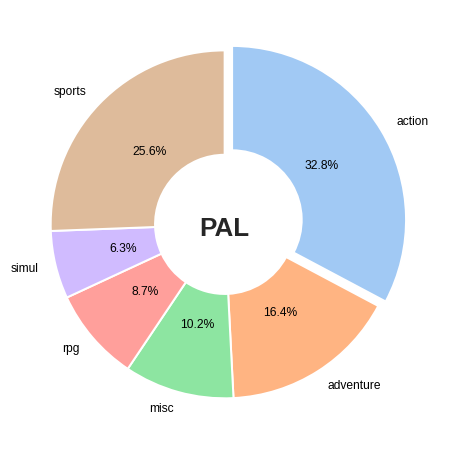

In [320]:
# PAL 지역의 비디오게임 장르 분포
## 설정
region = PAL # 지역 설정
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

## Pie Graph
values = df[region].groupby('gen_6').sum()['sales'].values
labels = df[region].groupby('gen_6').sum()['sales'].index

fig, ax = plt.subplots(figsize=(8,8))
text_dic = dict(rotation=0,size=12, weight=5, color="black")

ax.pie(values, labels=labels,
    radius=1,
    explode=(0.05,0,0,0,0,0),
    autopct='%.1f%%',
    textprops=text_dic,
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)

ax.set_title(df[region].region.unique()[0], fontsize=26, fontweight = 'bold', y=0.46)

## Summary
idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Count' : [group1.count(), group2.count(), group3.count(), group4.count(), group5.count(), group6.count()],
    'Total' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Mean' : [group1.mean(), group2.mean(), group3.mean(), group4.mean(), group5.mean(), group6.mean()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

results_summary = pd.DataFrame(data, index=idx)

## One-Way ANOVA
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

results_posthoc = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])

print(f"""
{results_summary.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{results_posthoc}
""")

# 분석결과 저장
file_name = '02_pal_genre_pie.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

file_name = '02_pal_genre_posthoc.xlsx'
results_posthoc.to_excel(path_results + file_name)

file_name = '02_pal_genre_summary.xlsx'
results_summary.to_excel(path_results + file_name)

wb = load_workbook(path_results + file_name) # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Summary')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기


           Count      Total      Mean  Rate
rpg         1239  385329999 311000.81  0.28
action      1973  263840000 133725.29  0.19
adventure   1536  235009999 153001.30  0.17
sports       929  210889998 227007.53  0.15
misc         927  178920000 193009.71  0.13
simul        644  121500000 188664.60  0.09

일원분산분석 결과
F = 26.867, p = 0.000

       group1     group2   meandiff  p-adj      lower     upper  reject
0      action  adventure   19276.01   0.79  -24788.98  63341.00   False
1      action       misc   59284.42   0.01    7719.21 110849.62    True
2      action        rpg  177275.51   0.00  130334.79 224216.23    True
3      action      simul   54939.30   0.08   -3830.81 113709.42   False
4      action     sports   93282.24   0.00   41754.81 144809.67    True
5   adventure       misc   40008.41   0.28  -13850.55  93867.36   False
6   adventure        rpg  157999.50   0.00  108550.06 207448.95    True
7   adventure      simul   35663.29   0.54  -25129.33  96455.92   False
8   adven

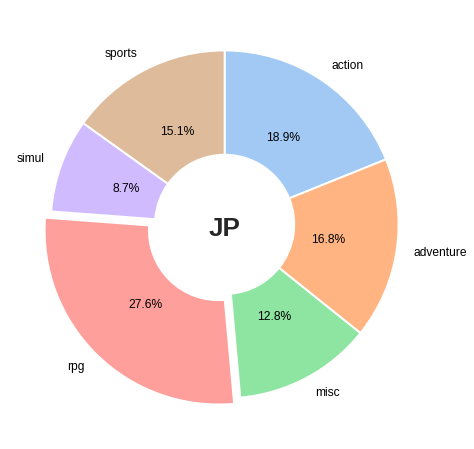

In [321]:
# JP 지역의 비디오게임 장르 분포
## 설정
region = JP # 지역 설정
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

## Pie Graph
values = df[region].groupby('gen_6').sum()['sales'].values
labels = df[region].groupby('gen_6').sum()['sales'].index

fig, ax = plt.subplots(figsize=(8,8))
text_dic = dict(rotation=0,size=12, weight=5, color="black")

ax.pie(values, labels=labels,
    radius=1,
    explode=(0,0,0,0.05,0,0),
    autopct='%.1f%%',
    textprops=text_dic,
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)

ax.set_title(df[region].region.unique()[0], fontsize=26, fontweight = 'bold', y=0.46)

## Summary
idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Count' : [group1.count(), group2.count(), group3.count(), group4.count(), group5.count(), group6.count()],
    'Total' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Mean' : [group1.mean(), group2.mean(), group3.mean(), group4.mean(), group5.mean(), group6.mean()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

results_summary = pd.DataFrame(data, index=idx)

## One-Way ANOVA
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

results_posthoc = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])

print(f"""
{results_summary.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{results_posthoc}
""")

# 분석결과 저장
file_name = '02_jp_genre_pie.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

file_name = '02_jp_genre_posthoc.xlsx'
results_posthoc.to_excel(path_results + file_name)

file_name = '02_jp_genre_summary.xlsx'
results_summary.to_excel(path_results + file_name)

wb = load_workbook(path_results + file_name) # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Summary')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기


           Count      Total     Mean  Rate
action      3334  308170000 92432.51  0.35
sports      2627  234729999 89352.87  0.27
adventure   1670  125520000 75161.68  0.14
misc        1480   92440000 62459.46  0.11
rpg          949   72880000 76796.63  0.08
simul        929   42660000 45920.34  0.05

일원분산분석 결과
F = 8.488, p = 0.000

       group1     group2  meandiff  p-adj     lower     upper  reject
0      action  adventure -17270.84   0.14 -37280.80   2739.13   False
1      action       misc -29973.05   0.00 -50821.23  -9124.88    True
2      action        rpg -15635.89   0.46 -40193.54   8921.77   False
3      action      simul -46512.17   0.00 -71274.74 -21749.60    True
4      action     sports  -3079.64   0.90 -20492.71  14333.43   False
5   adventure       misc -12702.22   0.63 -36530.62  11126.19   False
6   adventure        rpg   1634.95   0.90 -25498.51  28768.41   False
7   adventure      simul -29241.33   0.03 -56560.39  -1922.27    True
8   adventure     sports  14191.20 

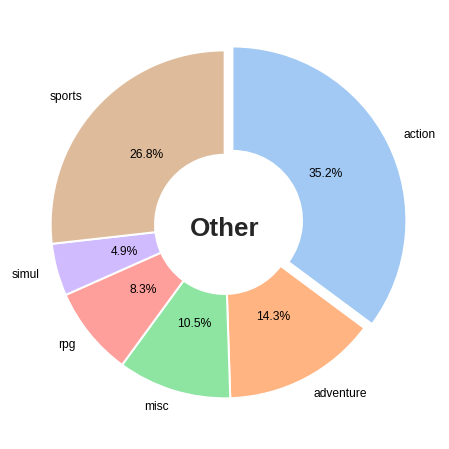

In [322]:
# Other 지역의 비디오게임 장르 분포
## 설정
region = Other # 지역 설정
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

## Pie Graph
values = df[region].groupby('gen_6').sum()['sales'].values
labels = df[region].groupby('gen_6').sum()['sales'].index

fig, ax = plt.subplots(figsize=(8,8))
text_dic = dict(rotation=0,size=12, weight=5, color="black")

ax.pie(values, labels=labels,
    radius=1,
    explode=(0.05,0,0,0,0,0),
    autopct='%.1f%%',
    textprops=text_dic,
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)

ax.set_title(df[region].region.unique()[0], fontsize=26, fontweight = 'bold', y=0.46)

## Summary
idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Count' : [group1.count(), group2.count(), group3.count(), group4.count(), group5.count(), group6.count()],
    'Total' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Mean' : [group1.mean(), group2.mean(), group3.mean(), group4.mean(), group5.mean(), group6.mean()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

results_summary = pd.DataFrame(data, index=idx)

## One-Way ANOVA
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

results_posthoc = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])

print(f"""
{results_summary.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{results_posthoc}
""")

# 분석결과 저장
file_name = '02_other_genre_pie.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

file_name = '02_other_genre_posthoc.xlsx'
results_posthoc.to_excel(path_results + file_name)

file_name = '02_other_genre_summary.xlsx'
results_summary.to_excel(path_results + file_name)

wb = load_workbook(path_results + file_name) # 엑셀파일 불러오기
ws = wb.active
ws.insert_rows(1, 4) # x번째 행에 y개 행 추가
ws.cell(row=1, column=1, value='One-Way ANOVA') # 셀에 내용입력
ws.cell(row=2, column=1, value='F-stat')
ws.cell(row=2, column=2, value='%.3f'%(F_statistic))
ws.cell(row=2, column=3, value='P-val')
ws.cell(row=2, column=4, value='%.3f'%(pVal))
ws.cell(row=4, column=1, value='Summary')
wb.save(path_results + file_name) # 엑셀파일 저장
wb.close()  # 엑셀파일 닫기

In [323]:
# 이원분산분석(two-way ANOVA) : statmodels
formula = 'sales ~ C(region) + C(gen_6) + C(region):C(gen_6)'
lm = ols(formula, df).fit()
results = anova_lm(lm, typ=3)

# 분석결과 저장
file_name = '02_twoway_anova.xlsx'
results.to_excel(path_results + file_name)

results

,sum_sq,df,F,PR(>F)
Intercept,35282080892038.41,1.00,85.30,0.00
C(region),186714193183639.09,3.00,150.46,0.00
C(gen_6),27726563563959.32,5.00,13.41,0.00
C(region):C(gen_6),37261038338771.63,15.00,6.01,0.00
Residual,17904297666770272.00,43284.00,NaN,NaN


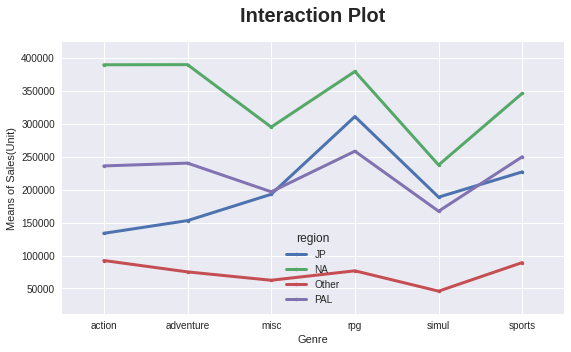

In [324]:
fig, ax = plt.subplots(figsize=(9, 5))
fig = interaction_plot(df.gen_6, df.region, df.sales, 
                        colors=sns.color_palette()[0:4],
                        lw = '3',
                        ax=ax)
plt.title('Interaction Plot', fontsize=20, fontweight = 'bold', pad=20)
plt.xlabel('Genre')
plt.ylabel('Means of Sales(Unit)')

# 분석결과 저장
file_name = '02_interaction_plot.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

이원분산분석 + 사후검정
[ANOVA + Tukey Test In Python](https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda)

In [325]:
df['combination'] = df.region + ' / ' + df.gen_6 # 상호작용항 만들기
posthoc = pairwise_tukeyhsd(df.sales, df.combination, alpha=0.05)

In [326]:
posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
posthoc_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,JP / action,JP / adventure,19276.01,0.90,-60333.50,98885.52,False
1,JP / action,JP / misc,59284.42,0.77,-33875.26,152444.10,False
2,JP / action,JP / rpg,177275.51,0.00,92470.61,262080.42,True
3,JP / action,JP / simul,54939.30,0.90,-51237.05,161115.66,False
4,JP / action,JP / sports,93282.24,0.05,190.81,186373.67,True
...,...,...,...,...,...,...,...
271,PAL / misc,PAL / simul,-29506.50,0.90,-125801.46,66788.46,False
272,PAL / misc,PAL / sports,53225.28,0.63,-23442.74,129893.30,False
273,PAL / rpg,PAL / simul,-91144.01,0.23,-197881.47,15593.46,False
274,PAL / rpg,PAL / sports,-8412.23,0.90,-97844.62,81020.16,False


In [327]:
posthoc_df['group1_reg'] = posthoc_df['group1'].str.split(' / ', n=2, expand=True)[0]
posthoc_df['group1_gen'] = posthoc_df['group1'].str.split(' / ', n=2, expand=True)[1]
posthoc_df['group2_reg'] = posthoc_df['group2'].str.split(' / ', n=2, expand=True)[0]
posthoc_df['group2_gen'] = posthoc_df['group2'].str.split(' / ', n=2, expand=True)[1]

In [328]:
# 상호작용항을 분해한 사후검정
posthoc_df = posthoc_df[['group1_reg', 'group1_gen', 'group2_reg', 'group2_gen', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

# 분석결과 저장
file_name = '02_twoway_posthoc.xlsx'
posthoc_df.to_excel(path_results + file_name)

posthoc_df

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
0,JP,action,JP,adventure,19276.01,0.90,-60333.50,98885.52,False
1,JP,action,JP,misc,59284.42,0.77,-33875.26,152444.10,False
2,JP,action,JP,rpg,177275.51,0.00,92470.61,262080.42,True
3,JP,action,JP,simul,54939.30,0.90,-51237.05,161115.66,False
4,JP,action,JP,sports,93282.24,0.05,190.81,186373.67,True
...,...,...,...,...,...,...,...,...,...
271,PAL,misc,PAL,simul,-29506.50,0.90,-125801.46,66788.46,False
272,PAL,misc,PAL,sports,53225.28,0.63,-23442.74,129893.30,False
273,PAL,rpg,PAL,simul,-91144.01,0.23,-197881.47,15593.46,False
274,PAL,rpg,PAL,sports,-8412.23,0.90,-97844.62,81020.16,False


In [329]:
# action 장르 비교
filter1 = posthoc_df.group1_gen == "action"
filter2 = posthoc_df.group2_gen == "action"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
5,JP,action,NA,action,255897.17,0.00,191874.83,319919.51,True
11,JP,action,Other,action,-41292.78,0.81,-107745.17,25159.61,False
17,JP,action,PAL,action,102302.94,0.00,37247.25,167358.64,True
128,NA,action,Other,action,-297189.94,0.00,-351654.43,-242725.45,True
134,NA,action,PAL,action,-153594.22,0.00,-206345.56,-100842.88,True
215,Other,action,PAL,action,143595.72,0.00,87920.19,199271.25,True


In [330]:
# adventure 장르 비교
filter1 = posthoc_df.group1_gen == "adventure"
filter2 = posthoc_df.group2_gen == "adventure"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
28,JP,adventure,NA,adventure,236792.61,0.00,157740.77,315844.45,True
34,JP,adventure,Other,adventure,-77839.62,0.10,-160550.06,4870.81,False
40,JP,adventure,PAL,adventure,87296.48,0.02,6507.08,168085.87,True
145,NA,adventure,Other,adventure,-314632.24,0.00,-391854.40,-237410.08,True
151,NA,adventure,PAL,adventure,-149496.13,0.00,-224657.10,-74335.16,True
226,Other,adventure,PAL,adventure,165136.10,0.00,86136.14,244136.07,True


In [331]:
# misc 장르 비교
filter1 = posthoc_df.group1_gen == "misc"
filter2 = posthoc_df.group2_gen == "misc"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
50,JP,misc,NA,misc,102025.75,0.02,7735.70,196315.80,True
56,JP,misc,Other,misc,-130550.25,0.00,-228544.30,-32556.19,True
62,JP,misc,PAL,misc,3768.62,0.90,-95255.65,102792.90,False
161,NA,misc,Other,misc,-232576.00,0.00,-314334.15,-150817.85,True
167,NA,misc,PAL,misc,-98257.13,0.00,-181247.29,-15266.97,True
236,Other,misc,PAL,misc,134318.87,0.00,47143.25,221494.49,True


In [332]:
# rpg 장르 비교
filter1 = posthoc_df.group1_gen == "rpg"
filter2 = posthoc_df.group2_gen == "rpg"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
71,JP,rpg,NA,rpg,68475.38,0.62,-29659.86,166610.63,False
77,JP,rpg,Other,rpg,-234204.18,0.00,-335126.52,-133281.84,True
83,JP,rpg,PAL,rpg,-52584.97,0.90,-154756.98,49587.05,False
176,NA,rpg,Other,rpg,-302679.56,0.00,-407467.44,-197891.68,True
182,NA,rpg,PAL,rpg,-121060.35,0.01,-227052.34,-15068.36,True
245,Other,rpg,PAL,rpg,181619.21,0.00,73041.62,290196.81,True


In [333]:
# simul 장르 비교
filter1 = posthoc_df.group1_gen == "simul"
filter2 = posthoc_df.group2_gen == "simul"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
91,JP,simul,NA,simul,48803.41,0.90,-67396.48,165003.30,False
97,JP,simul,Other,simul,-142744.25,0.00,-262706.88,-22781.62,True
103,JP,simul,PAL,simul,-21392.76,0.90,-139166.51,96380.99,False
190,NA,simul,Other,simul,-191547.66,0.00,-295926.83,-87168.49,True
196,NA,simul,PAL,simul,-70196.17,0.64,-172052.12,31659.78,False
253,Other,simul,PAL,simul,121351.49,0.01,15223.01,227479.97,True


In [334]:
# sports 장르 비교
filter1 = posthoc_df.group1_gen == "sports"
filter2 = posthoc_df.group2_gen == "sports"
results = posthoc_df[filter1][filter2]

results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
110,JP,sports,NA,sports,119284.74,0.00,32163.69,206405.78,True
116,JP,sports,Other,sports,-137654.66,0.00,-226959.58,-48349.74,True
122,JP,sports,PAL,sports,22996.08,0.90,-65708.60,111700.76,False
203,NA,sports,Other,sports,-256939.40,0.00,-318435.86,-195442.93,True
209,NA,sports,PAL,sports,-96288.66,0.00,-156910.16,-35667.16,True
260,Other,sports,PAL,sports,160650.74,0.00,96930.58,224370.90,True


### 연도에 따라 비디오 게임의 인기 플랫폼이 다른가?

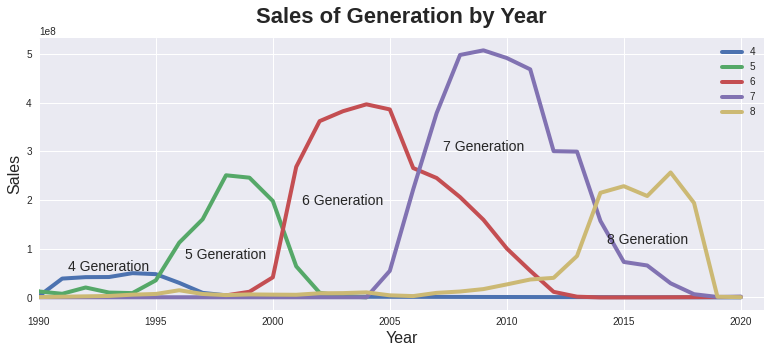

In [335]:
tt_year = df_total.Year == 9999

## 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 5))

for pf in [4,5,6,7,8]:
  x = df_total[~tt_year][df_total.pf_gens == pf].groupby('Year').sum()['Total_Sales'].index
  y = df_total[~tt_year][df_total.pf_gens == pf].groupby('Year').sum()['Total_Sales'].values
  ax.plot(x, y, lw=4, label=pf)

plt.text(1993, 10**8*0.55, '4 Generation', ha='center', fontsize=14)
plt.text(1998, 10**8*0.8, '5 Generation', ha='center', fontsize=14)
plt.text(2003, 10**8*1.9, '6 Generation', ha='center', fontsize=14)
plt.text(2009, 10**8*3, '7 Generation', ha='center', fontsize=14)
plt.text(2016, 10**8*1.1, '8 Generation', ha='center', fontsize=14)

plt.title('Sales of Generation by Year', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales', fontsize=16)

plt.xlim(1990, 2021)          

ax.legend()
plt.show()

# 분석결과 저장
file_name = '03_generation_year.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

In [336]:
df_total.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'Score', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'Year', 'pf_name',
       'pf_gens', 'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7',
       'Platform_3', 'gen_6'],
      dtype='object')

In [337]:
result = df_total.sort_values('Total_Sales', ascending=False).head(10)[['Name','Total_Sales','pf_gens','Genre','pf_name','Year']]

file_name = '03_total_sales.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Total_Sales,pf_gens,Genre,pf_name,Year
52793,Wii Sports,82650000.00,7,Sports,Wii,2006
28264,Super Mario Bros.,40240000.00,3,Platform,Nintendo Entertainment System,1985
35593,Mario Kart Wii,35980000.00,7,Racing,Wii,2008
52795,Wii Sports Resort,32900000.00,7,Sports,Wii,2009
38936,Pokémon Red / Green / Blue Version,31370000.00,5,Role-Playing,Game Boy,1998
32160,Tetris,30260000.00,5,Puzzle,Game Boy,1989
28266,New Super Mario Bros.,29850000.00,6,Platform,Nintendo DS,2006
18431,Wii Play,28920000.00,7,Misc,Wii,2007
28267,New Super Mario Bros. Wii,28510000.00,7,Platform,Wii,2009
44479,Duck Hunt,28310000.00,3,Shooter,Nintendo Entertainment System,1985


In [338]:
filt = df_total.pf_gens == 5
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','pf_name','Year']]

file_name = '03_5gen.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Total_Sales,pf_gens,Genre,pf_name,Year
38936,Pokémon Red / Green / Blue Version,31370000.00,5,Role-Playing,Game Boy,1998
32160,Tetris,30260000.00,5,Puzzle,Game Boy,1989
38941,Pokémon Gold / Silver Version,23100000.00,5,Role-Playing,Game Boy,2000
28275,Super Mario Land,18140000.00,5,Platform,Game Boy,1989
38960,Pokémon Yellow: Special Pikachu Edition,14640000.00,5,Role-Playing,Game Boy,1999


In [339]:
filt = df_total.pf_gens == 6
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','pf_name','Year']]

file_name = '03_6gen.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Total_Sales,pf_gens,Genre,pf_name,Year
28266,New Super Mario Bros.,29850000.00,6,Platform,Nintendo DS,2006
49752,Nintendogs,24680000.00,6,Simulation,Nintendo DS,2005
35594,Mario Kart DS,23260000.00,6,Racing,Nintendo DS,2005
9,Grand Theft Auto: San Andreas,20810000.00,6,Action,PlayStation 2,2004
18433,Brain Age: Train Your Brain in Minutes a Day,20160000.00,6,Misc,Nintendo DS,2006


In [340]:
filt = df_total.pf_gens == 7
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','pf_name','Year']]

file_name = '03_7gen.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Total_Sales,pf_gens,Genre,pf_name,Year
52793,Wii Sports,82650000.00,7,Sports,Wii,2006
35593,Mario Kart Wii,35980000.00,7,Racing,Wii,2008
52795,Wii Sports Resort,32900000.00,7,Sports,Wii,2009
18431,Wii Play,28920000.00,7,Misc,Wii,2007
28267,New Super Mario Bros. Wii,28510000.00,7,Platform,Wii,2009


In [341]:
filt = df_total.pf_gens == 8
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','pf_name','Year']]

file_name = '03_8gen.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Total_Sales,pf_gens,Genre,pf_name,Year
8,Grand Theft Auto V,19390000.00,8,Action,PlayStation 4,2014
44490,Call of Duty: Black Ops 3,15090000.00,8,Shooter,PlayStation 4,2015
8403,Red Dead Redemption 2,13940000.00,8,Action-Adventure,PlayStation 4,2018
44501,Call of Duty: WWII,13400000.00,8,Shooter,PlayStation 4,2017
35592,Mario Kart 8 Deluxe,13050000.00,8,Racing,Nintendo Switch,2017


### 인기가 많은 게임은 무엇?

In [342]:
coff_df = df_total[['Score','Total_Sales']].corr()
coff_df # 스코어와 판매량의 상관관계가 낮음

,Score,Total_Sales
Score,1.00,0.33
Total_Sales,0.33,1.00


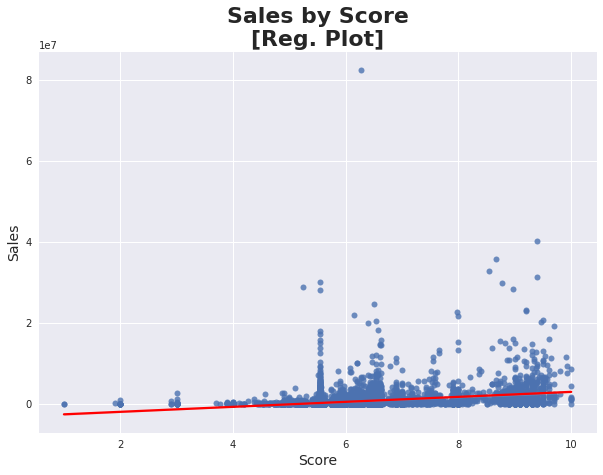

In [343]:
## 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 7))

sns.set_theme(color_codes=True)

ax = sns.regplot(x="Score", y="Total_Sales", data=df_total,
            scatter_kws={"color": "b"}, line_kws={"color": "red"})

## 그래프 설정
plt.title('Sales by Score\n[Reg. Plot]', fontsize=22, fontweight = 'bold');

plt.xlabel('Score', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.show()

file_name = '04_sales_score.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

In [344]:
result = df[NA].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

file_name = '04_sales_na.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Genre,Platform,Year,sales
16505,Wii Sports,Sports,Wii,2006,41360000
8568,Super Mario Bros.,Platform,NES,1985,29080000
13724,Duck Hunt,Shooter,NES,1985,26930000
9669,Tetris,Puzzle,GB,1989,23200000
10428,Mario Kart Wii,Racing,Wii,2008,15910000


In [345]:
result = df[PAL].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

file_name = '04_sales_pal.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Genre,Platform,Year,sales
36810,Wii Sports,Sports,Wii,2006,29020000
30733,Mario Kart Wii,Racing,Wii,2008,12920000
36811,Wii Sports Resort,Sports,Wii,2009,10990000
35624,Nintendogs,Simulation,DS,2005,10960000
20305,Grand Theft Auto V,Action,PS3,2013,9850000


In [346]:
result = df[JP].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

file_name = '04_sales_jp.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Genre,Platform,Year,sales
52534,Pokémon Red / Green / Blue Version,Role-Playing,GB,1998,10220000
52535,Pokémon Gold / Silver Version,Role-Playing,GB,2000,7200000
49178,Super Mario Bros.,Platform,NES,1985,6810000
49179,New Super Mario Bros.,Platform,DS,2006,6500000
52536,Pokémon Diamond / Pearl Version,Role-Playing,DS,2007,6040000


In [347]:
result = df[Other].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

file_name = '04_sales_other.xlsx'
result.to_excel(path_results + file_name)

result

,Name,Genre,Platform,Year,sales
60918,Grand Theft Auto: San Andreas,Action,PS2,2004,10570000
77420,Wii Sports,Sports,Wii,2006,8510000
71348,Gran Turismo 4,Racing,PS2,2005,7530000
71343,Mario Kart Wii,Racing,Wii,2008,3350000
60915,Grand Theft Auto V,Action,PS3,2013,3120000


# 미디어패널 조사

In [348]:
for i in range(10,22):
  mp_path = path_data + 'media_panel/h{}v28_KMP_csv.csv'.format(i)
  mp_raw = pd.read_csv(mp_path, encoding='cp949')
  print(i, ' : ', mp_raw.shape)
  globals()['mp_h{}_raw'.format(i)] = mp_raw

10  :  (3085, 865)
11  :  (4539, 827)
12  :  (4414, 853)
13  :  (4381, 908)
14  :  (4313, 940)
15  :  (4305, 961)
16  :  (4233, 951)
17  :  (4203, 1007)
18  :  (4162, 1056)
19  :  (4583, 930)
20  :  (4260, 816)
21  :  (4171, 879)


In [349]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_h10_raw  카운트 :  h10a09001
2            2486
1             599
dtype: int64
mp_h10_raw  결측치 :  h10a09001    0
dtype: int64
mp_h11_raw  카운트 :  h11a09001
2            3898
1             641
dtype: int64
mp_h11_raw  결측치 :  h11a09001    0
dtype: int64
mp_h12_raw  카운트 :  h12a09001
2            2968
2             874
1             422
1             149
                1
dtype: int64
mp_h12_raw  결측치 :  h12a09001    0
dtype: int64
mp_h13_raw  카운트 :  h13a09001
2            3933
1             448
dtype: int64
mp_h13_raw  결측치 :  h13a09001    0
dtype: int64
mp_h14_raw  카운트 :  h14a09001
2            3984
1             329
dtype: int64
mp_h14_raw  결측치 :  h14a09001    0
dtype: int64
mp_h15_raw  카운트 :  h15a09001
2            4013
1             292
dtype: int64
mp_h15_raw  결측치 :  h15a09001    0
dtype: int64
mp_h16_raw  카운트 :  h16a09001
2            4021
1             212
dtype: int64
mp_h16_raw  결측치 :  h16a09001    0
dtype: int64
mp_h17_raw  카운트 :  h17a09001
2            4013
1             190
dtype:

In [350]:
mp_h12_raw.h12a09001.unique()

array([1, 2, '2', '1', ' '], dtype=object)

In [351]:
filt = mp_h12_raw.h12a09001 == ' '
mp_h12_raw.drop(index=mp_h12_raw[filt].index, inplace=True)
mp_h12_raw.h12a09001.unique()

array([1, 2, '2', '1'], dtype=object)

In [352]:
mp_h12_raw.h12a09001 = mp_h12_raw.h12a09001.astype(int)

In [353]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_h10_raw  카운트 :  h10a09001
2            2486
1             599
dtype: int64
mp_h10_raw  결측치 :  h10a09001    0
dtype: int64
mp_h11_raw  카운트 :  h11a09001
2            3898
1             641
dtype: int64
mp_h11_raw  결측치 :  h11a09001    0
dtype: int64
mp_h12_raw  카운트 :  h12a09001
2            3842
1             571
dtype: int64
mp_h12_raw  결측치 :  h12a09001    0
dtype: int64
mp_h13_raw  카운트 :  h13a09001
2            3933
1             448
dtype: int64
mp_h13_raw  결측치 :  h13a09001    0
dtype: int64
mp_h14_raw  카운트 :  h14a09001
2            3984
1             329
dtype: int64
mp_h14_raw  결측치 :  h14a09001    0
dtype: int64
mp_h15_raw  카운트 :  h15a09001
2            4013
1             292
dtype: int64
mp_h15_raw  결측치 :  h15a09001    0
dtype: int64
mp_h16_raw  카운트 :  h16a09001
2            4021
1             212
dtype: int64
mp_h16_raw  결측치 :  h16a09001    0
dtype: int64
mp_h17_raw  카운트 :  h17a09001
2            4013
1             190
dtype: int64
mp_h17_raw  결측치 :  h17a09001    0
dtype: int64


In [354]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, globals()[i].iloc[:,np.where(filt)[0]].value_counts(normalize=True)[1])

mp_h10_raw 0.19416531604538087
mp_h11_raw 0.14122053315708305
mp_h12_raw 0.1293904373442103
mp_h13_raw 0.10225975804610819
mp_h14_raw 0.07628101089728727
mp_h15_raw 0.0678281068524971
mp_h16_raw 0.050082683675879994
mp_h17_raw 0.04520580537711159
mp_h18_raw 0.0422873618452667
mp_h19_raw 0.05062186340824787
mp_h20_raw 0.05352112676056338
mp_h21_raw 0.05082713977463438


In [355]:
merge_mp = mp_h10_raw.hid

merge_mp = pd.merge(left = merge_mp, right = mp_h10_raw[['hid','h10a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h11_raw[['hid','h11a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h12_raw[['hid','h12a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h13_raw[['hid','h13a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h14_raw[['hid','h14a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h15_raw[['hid','h15a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h16_raw[['hid','h16a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h17_raw[['hid','h17a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h18_raw[['hid','h18a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h19_raw[['hid','h19a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h20_raw[['hid','h20a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h21_raw[['hid','h21a09001']], how = 'outer', on = 'hid')

merge_mp

,hid,h10a09001,h11a09001,h12a09001,h13a09001,h14a09001,h15a09001,h16a09001,h17a09001,h18a09001,h19a09001,h20a09001,h21a09001
0,100.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00
1,800.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
2,900.00,2.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,NaN
3,1100.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,NaN,NaN,NaN
4,1300.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,694101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8476,1046701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8477,1046901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8478,1048601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00


In [356]:
merge_mp.columns

Index(['hid', 'h10a09001', 'h11a09001', 'h12a09001', 'h13a09001', 'h14a09001',
       'h15a09001', 'h16a09001', 'h17a09001', 'h18a09001', 'h19a09001',
       'h20a09001', 'h21a09001'],
      dtype='object')

In [357]:
merge_mp.rename(columns={
                        'h10a09001' : '2010',
                        'h11a09001' : '2011',
                        'h12a09001' : '2012',
                        'h13a09001' : '2013',
                        'h14a09001' : '2014',
                        'h15a09001' : '2015',
                        'h16a09001' : '2016',
                        'h17a09001' : '2017',
                        'h18a09001' : '2018',
                        'h19a09001' : '2019',
                        'h20a09001' : '2020',
                        'h21a09001' : '2021'
                        }, inplace=True)
merge_mp.columns

Index(['hid', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021'],
      dtype='object')

In [358]:
merge_mp.columns[1:]

Index(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021'],
      dtype='object')

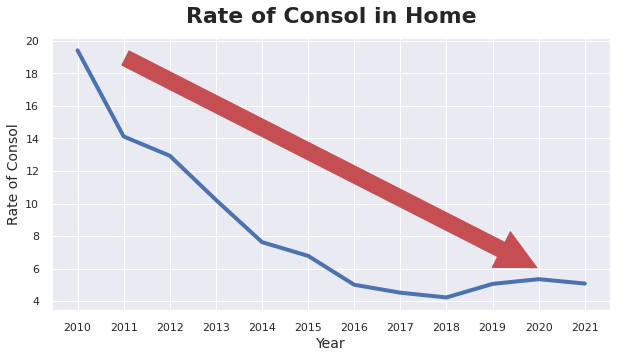

In [359]:
fig, ax = plt.subplots(figsize=(10, 5))

# ax = fig.add_subplot(2, 1, 2)
# fig = plt.figure(figsize=(8,8))  

consol_rate = []

for year in merge_mp.columns[1:]:
  consol_rate.append(merge_mp[year].value_counts(normalize=True)[1]*100)

ax.plot(merge_mp.columns[1:], consol_rate, lw=4)

arrow = mpatches.FancyArrowPatch((1, 19), (10, 6),
                                 mutation_scale=80,
                                 color="r")
ax.add_patch(arrow)


## 그래프 설정
plt.title('Rate of Consol in Home', fontsize=22, fontweight = 'bold', pad=15)


plt.xlabel('Year', fontsize=14)
plt.ylabel('Rate of Consol', fontsize=14)



plt.show()

file_name = '05_rate_consol_home.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')

In [360]:
for i in range(17,22):
  mp_path = path_data + 'media_panel/p{}v28_KMP_csv.csv'.format(i)
  mp_raw = pd.read_csv(mp_path, encoding='cp949')
  print(i, ' : ', mp_raw.shape)
  globals()['mp_p{}_raw'.format(i)] = mp_raw

17  :  (9425, 433)
18  :  (9426, 423)
19  :  (10864, 432)
20  :  (10302, 487)
21  :  (10154, 511)


In [361]:
for i in globals():
  if i[0:4] == 'mp_p' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('c05043')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_p17_raw  카운트 :  p17c05043
             9061
1             299
3              55
2               6
4               4
dtype: int64
mp_p17_raw  결측치 :  p17c05043    0
dtype: int64
mp_p18_raw  카운트 :  p18c05043
             7974
1            1275
3             161
2               9
4               7
dtype: int64
mp_p18_raw  결측치 :  p18c05043    0
dtype: int64
mp_p19_raw  카운트 :  p19c05043
             9314
1            1385
3             135
4              16
2              14
dtype: int64
mp_p19_raw  결측치 :  p19c05043    0
dtype: int64
mp_p20_raw  카운트 :  p20c05043
             8314
1            1780
3             182
2              21
4               5
dtype: int64
mp_p20_raw  결측치 :  p20c05043    0
dtype: int64
mp_p21_raw  카운트 :  p21c05043
             7512
1            2350
3             250
2              29
4              13
dtype: int64
mp_p21_raw  결측치 :  p21c05043    0
dtype: int64


In [362]:
mp_p = mp_p17_raw.pid

mp_p = pd.merge(left = mp_p, right = mp_p17_raw[['pid','p17c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p18_raw[['pid','p18c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p19_raw[['pid','p19c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p20_raw[['pid','p20c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p21_raw[['pid','p21c05043']], how = 'outer', on = 'pid')

mp_p

,pid,p17c05043,p18c05043,p19c05043,p20c05043,p21c05043
0,10001,,,,1,1
1,10002,,1,,1,1
2,20001,,,,,
3,30001,,,,,
4,30002,,,,,
...,...,...,...,...,...,...
13012,117880004,NaN,NaN,NaN,NaN,1
13013,117910002,NaN,NaN,NaN,NaN,
13014,117940003,NaN,NaN,NaN,NaN,
13015,118140005,NaN,NaN,NaN,NaN,1


In [363]:
mp_p.rename(columns={
                    'p17c05043' : '2017',
                    'p18c05043' : '2018',
                    'p19c05043' : '2019',
                    'p20c05043' : '2020',
                    'p21c05043' : '2021'
                    }, inplace=True)
mp_p.columns

Index(['pid', '2017', '2018', '2019', '2020', '2021'], dtype='object')

In [364]:
mp_p['2017'].value_counts(normalize=True).sort_index()['1']

0.031724137931034485

In [365]:
mp_p['2017'].value_counts(normalize=True).sort_index()

    0.96
1   0.03
2   0.00
3   0.01
4   0.00
Name: 2017, dtype: float64

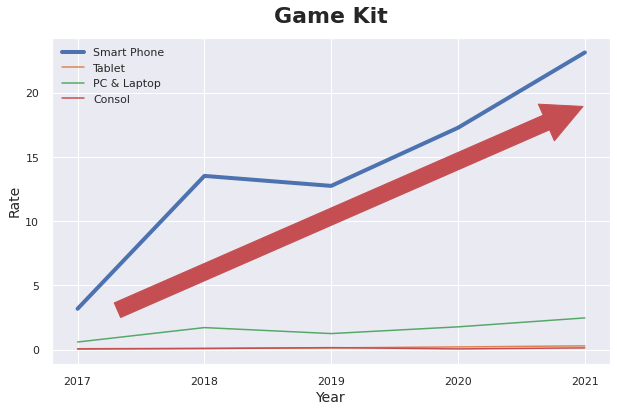

In [375]:
fig, ax = plt.subplots(figsize=(10, 6))

smart_phone = []
tablet = []
PC_laptop = []
consol = []

for year in mp_p.columns[1:]:
  smart_phone.append(mp_p[year].value_counts(normalize=True).sort_index()['1']*100)
  tablet.append(mp_p[year].value_counts(normalize=True).sort_index()['2']*100)
  PC_laptop.append(mp_p[year].value_counts(normalize=True).sort_index()['3']*100)
  consol.append(mp_p[year].value_counts(normalize=True).sort_index()['4']*100)

ax.plot(mp_p.columns[1:], smart_phone, label='Smart Phone', lw=4)
ax.plot(mp_p.columns[1:], tablet, label='Tablet')
ax.plot(mp_p.columns[1:], PC_laptop, label='PC & Laptop')
ax.plot(mp_p.columns[1:], consol, label='Consol')

arrow = mpatches.FancyArrowPatch((0.3, 3), (4, 19),
                                 mutation_scale=80,
                                 color="r")
ax.add_patch(arrow)

## 그래프 설정
plt.title('Game Kit', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Rate', fontsize=14)

ax.legend()
plt.show()

file_name = '05_game_kit.png'
fig.savefig(path_results + file_name, dpi=150, facecolor='#eeeeee')